In [1]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings

In [2]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel
from gammapy.irf import EDispKernel, PSFMap, PSFKernel
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion
from hawc_dataset import HAWCMapDataset
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
)
from gammapy.modeling.models import Models

In [3]:
import gammapy
gammapy.__version__

'0.18.2'

In [4]:
spatial_model = PointSpatialModel(
    lon_0="83.63 deg",
    lat_0="22.01 deg",
    frame="icrs"
)

spectral_model = LogParabolaSpectralModel(
        amplitude="2.6e-13 TeV-1 cm-2 s-1",
        alpha=2.65,
        beta=0.1,
        reference="7 TeV"
)

spectral_model.amplitude.error = "0.07e-13 TeV-1 cm-2 s-1"
spectral_model.beta.error = 0.015
spectral_model.alpha.error = 0.019

model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name='crab model')

In [5]:
%%time
models = Models([])
datasets = Datasets()
hawc_datasets_nHitBin = []

for i in range(1,10):
    dataset =  HAWCMapDataset.read('gammapy_dataset_vikas/crab-{}nHitBin.fits.gz'.format(i))
    dataset._models = models.copy()
    dataset.models.append(model)
    hawc_datasets_nHitBin.append(dataset)

CPU times: user 1min 23s, sys: 5.39 s, total: 1min 29s
Wall time: 1min 31s


In [6]:
fit = Fit(hawc_datasets_nHitBin)

In [7]:
%%time
result = fit.run()

CPU times: user 5min 30s, sys: 3min 27s, total: 8min 58s
Wall time: 8min 59s


In [8]:
result.parameters.to_table().show_in_notebook()

In [9]:
ref_model = LogParabolaSpectralModel(
    amplitude="2.54e-13 TeV-1 cm-2 s-1",
    alpha=2.646,
    beta=0.104,
    reference="7 TeV"
)
ref_model.amplitude.error = "0.07e-13 TeV-1 cm-2 s-1"
ref_model.beta.error = 0.015
ref_model.alpha.error = 0.019

#Energy Estimators
ref_model_energy = LogParabolaSpectralModel(
    amplitude="2.35e-13 TeV-1 cm-2 s-1",
    #amplitude="20e-13 TeV-1 cm-2 s-1",
    alpha=2.79,
    beta=0.10,
    reference="7 TeV"
)
ref_model_energy.amplitude.error = "0.04e-13 TeV-1 cm-2 s-1"
ref_model_energy.beta.error = 0.02
ref_model_energy.alpha.error = 0.01

#Laura's
#Energy Estimators
laura_model_energy = LogParabolaSpectralModel(
    amplitude="2.25e-13 TeV-1 cm-2 s-1",
    #amplitude="20e-13 TeV-1 cm-2 s-1",
    alpha=2.80,
    beta=0.083,
    reference="7 TeV"
)
laura_model_energy.amplitude.error = "0.03e-13 TeV-1 cm-2 s-1"
laura_model_energy.beta.error = 0.007
laura_model_energy.alpha.error = 0.01

#Vikas's
#Energy Estimators
vikas_model_energy = LogParabolaSpectralModel(
    amplitude="2.26e-13 TeV-1 cm-2 s-1",
    #amplitude="20e-13 TeV-1 cm-2 s-1",
    alpha=2.78,
    beta=0.09,
    reference="7 TeV"
)
vikas_model_energy.amplitude.error = "0.04e-13 TeV-1 cm-2 s-1"
vikas_model_energy.beta.error = 0.01
vikas_model_energy.alpha.error = 0.02

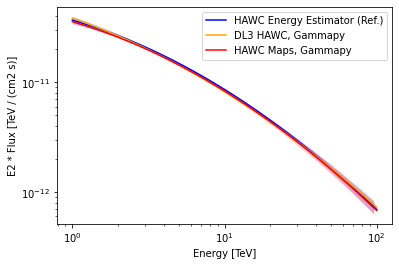

In [15]:
#ax = ref_model.plot(energy_range=(1, 100) * u.TeV, energy_power=2, label="HAWC Reference")
#ref_model.plot_error(energy_range=(1, 100) * u.TeV, energy_power=2, ax=ax, color=ax.lines[-1].get_color())
ax = ref_model_energy.plot(energy_range=(1, 100) * u.TeV, energy_power=2, label="HAWC Energy Estimator (Ref.)", color='blue')
ref_model_energy.plot_error(energy_range=(1, 100) * u.TeV, energy_power=2, ax=ax, color=ax.lines[-1].get_color())
laura_model_energy.plot(ax=ax, energy_range=(1, 100) * u.TeV, energy_power=2, label="DL3 HAWC, Gammapy", color='orange')
laura_model_energy.plot_error(energy_range=(1, 100) * u.TeV, energy_power=2, ax=ax, color=ax.lines[-1].get_color())
#vikas_model_energy.plot(ax=ax, energy_range=(1, 100) * u.TeV, energy_power=2, label="HAWC Maps, Gammapy", color='red')
#vikas_model_energy.plot_error(energy_range=(1, 100) * u.TeV, energy_power=2, ax=ax, color=ax.lines[-1].get_color())
spectral_model.plot(ax=ax, energy_range=(1, 100) * u.TeV, energy_power=2, label="HAWC Maps, Gammapy", color='red')
spectral_model.plot_error(ax=ax, energy_range=(1, 100) * u.TeV, energy_power=2, color=ax.lines[-1].get_color())

plt.legend()
plt.savefig("plots_vikas/energy-spectrum-nHitBins-laura.png", dpi=300, bbox_inches='tight')

In [11]:
npred = hawc_datasets_nHitBin[1].npred().data.sum(axis=1)
print(npred)
background = hawc_datasets_nHitBin[1].npred_background().get_spectrum().data.squeeze()
print(background)


[2497636.80158628 1241643.85893699  402916.2220213 ]
[2488544.41533455 1238329.20011235  402111.34911409]


In [12]:
counts_spectrum = []
npred_spectrum = []
background_spectrum = []
counts_residuals = []
models = Models([])
for i in range(9):
    counts = hawc_datasets_nHitBin[i].counts.data.sum(axis=1)
    npred = hawc_datasets_nHitBin[i].npred().data.sum(axis=1)
    background = hawc_datasets_nHitBin[i].npred_background().get_spectrum().data.squeeze()
    residuals = (counts - npred) / np.sqrt(npred)
    
    counts_spectrum.append(counts)
    npred_spectrum.append(npred)
    background_spectrum.append(background)
    counts_residuals.append(residuals)

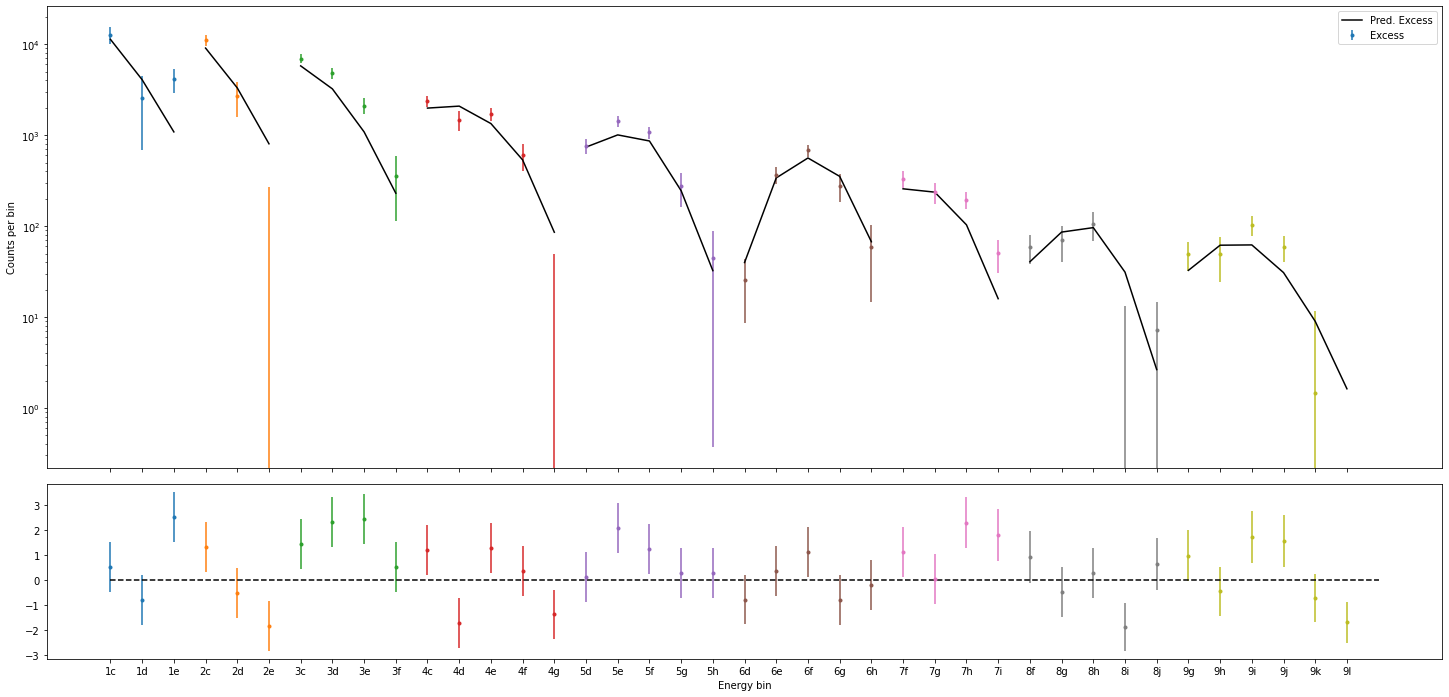

In [13]:
energy_bins = [['1c', '1d', '1e'], 
               ['2c', '2d', '2e'], 
               ['3c', '3d', '3e', '3f'], 
               ['4c', '4d', '4e', '4f', '4g'], 
               ['5d', '5e', '5f', '5g', '5h'], 
               ['6d', '6e', '6f', '6g', '6h'], 
               ['7f', '7g', '7h', '7i'], 
               ['8f', '8g', '8h', '8i', '8j'], 
               ['9g', '9h', '9i', '9j', '9k', '9l']]
               
plt.figure(figsize=(25, 12))
gs = GridSpec(7, 1)
ax = plt.subplot(gs[:5, :])
for i,ebins in enumerate(energy_bins):
    yerr = np.sqrt(counts_spectrum[i])
   
    if(i == 0):
        ax.plot(ebins, npred_spectrum[i] - background_spectrum[i], label="Pred. Excess", color="black")
        ax.errorbar(ebins, counts_spectrum[i] - background_spectrum[i], yerr=yerr, marker='o', ms=3, label="Excess", ls="None")
        
    else:
        ax.plot(ebins, npred_spectrum[i] - background_spectrum[i], color="black")
        ax.errorbar(ebins, counts_spectrum[i] - background_spectrum[i], yerr=yerr, marker='o', ms=3, ls="None")
        
ax.semilogy()
ax.set_ylabel("Counts per bin")
plt.setp(ax.get_xticklabels(), visible=False)
plt.legend()
ax_residuals = plt.subplot(gs[5:, :], sharex=ax)
for i,ebins in enumerate(energy_bins):
    yerr = np.sqrt(counts_spectrum[i])
    yerr = yerr / np.sqrt(npred_spectrum[i])
    ax_residuals.errorbar(ebins, counts_residuals[i], yerr=yerr, marker='o', ms=3, ls="None")

ax_residuals.hlines(0, 0, 40, ls="--", color="black")
ax_residuals.set_xlabel("Energy bin");
plt.savefig("plots_vikas/residual-counts-spectrum-nHitBins.png", dpi=300, bbox_inches='tight')

In [14]:
%%time
eaxis = MapAxis.from_bounds(1.00, 316, nbin=10, name="energy", interp="log", unit="TeV")
# Compute flux points for hawc energy estimator maps
fp_hawc_datasets_nHitBin = FluxPointsEstimator(energy_edges=eaxis.edges, source='crab model')
flux_points_hawc_datasets_nHitBin = fp_hawc_datasets_nHitBin.run(hawc_datasets_nHitBin)
flux_points_hawc_datasets_nHitBin.table["is_ul"] = flux_points_hawc_datasets_nHitBin.table["ts"] < 4

CPU times: user 13min 37s, sys: 12min 25s, total: 26min 3s
Wall time: 26min 5s


In [15]:
# for k,ds in enumerate(hawc_datasets_nHitBin):
#     ds.write('energy_estimator_fit_results/hawc_energy_estimator_fit_results_{}nHitBin.fits.gz'.format(k+1),overwrite=True)

flux_points_hawc_datasets_nHitBin.write("energy_estimator_fit_results/hawc_energy_estimator_flux_points.fits", overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: 'energy_estimator_fit_results/hawc_energy_estimator_flux_points.fits'

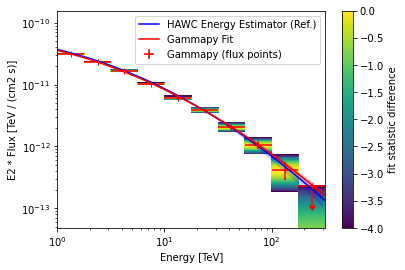

In [14]:
ax = ref_model_energy.plot(energy_range=(1, 316) * u.TeV, energy_power=2, label="HAWC Energy Estimator (Ref.)", color='blue')
ref_model_energy.plot_error(energy_range=(1, 316) * u.TeV, energy_power=2, ax=ax, color=ax.lines[-1].get_color())
flux_points_hawc_datasets_nHitBin.plot(ax=ax, energy_power=2, label="Gammapy (flux points)", color='red')
flux_points_hawc_datasets_nHitBin.to_sed_type("e2dnde").plot_ts_profiles(ax=ax, cmap='viridis',  y_unit="TeV cm-2 s-1")
spectral_model.plot(ax=ax, energy_range=(1, 316) * u.TeV, energy_power=2, label="Gammapy Fit",color='red')
spectral_model.plot_error(ax=ax, energy_range=(1, 316) * u.TeV, energy_power=2, color=ax.lines[-1].get_color())

plt.legend()
plt.savefig("plots_vikas/energy-spectrum-nHitBins-hawc-flux-points.png", dpi=300, bbox_inches='tight')

In [15]:
def plot_nhit_grid(hpx_map,event_class,**kwargs):
    from itertools import product
    ebins = energy_bins[event_class]
    plt.figure(figsize=(len(ebins)*10, 8))
    for idx,ebin in enumerate(ebins):
        image = hpx_map.get_image_by_idx((idx,))
        if image.geom.is_hpx:
            image_wcs = image.to_wcs(
                normalize=False,
                proj="AIT",
                oversample=2,
                width_pix=1000,
            )
        else:
            image_wcs = image
        ax = plt.subplot(1, len(ebins), idx + 1, projection=image_wcs.geom.wcs)
        image_wcs.plot(ax=ax, **kwargs)
        ax.set_title(f"Energy bin {ebin}")

In [16]:
npreds = []
residuals = []
for i in range(9):
    npred = hawc_datasets_nHitBin[i].npred()
    npreds.append(npred)
    residuals.append((hawc_datasets_nHitBin[i].counts - npred) / np.sqrt(npred.data))

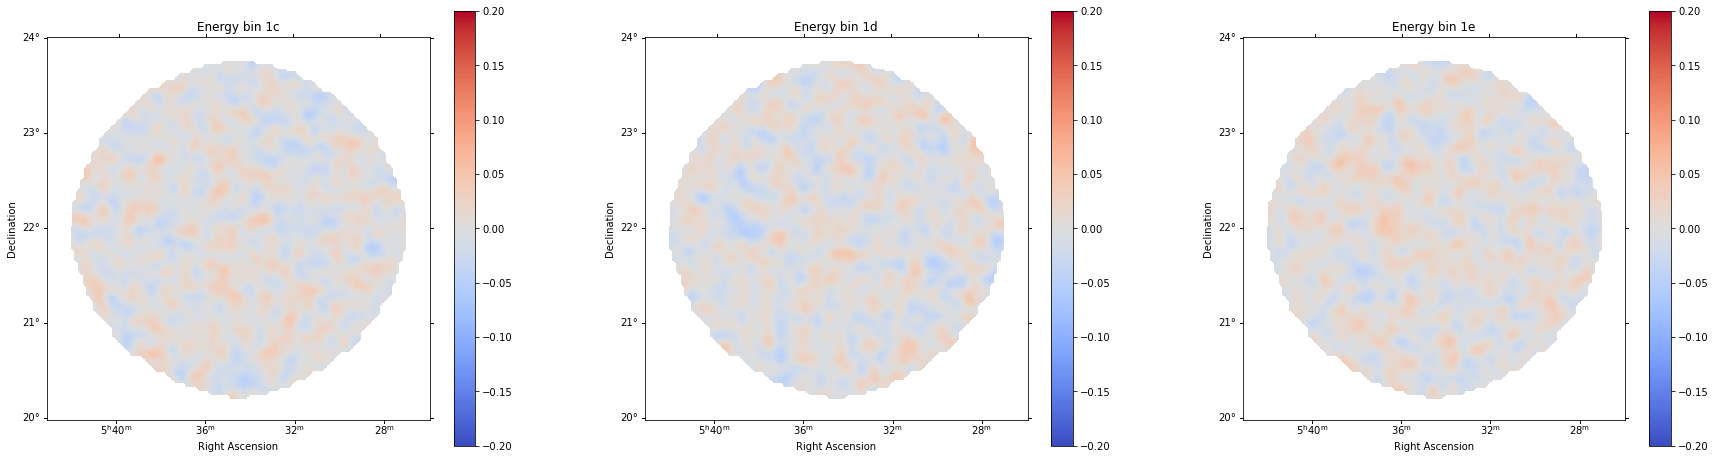

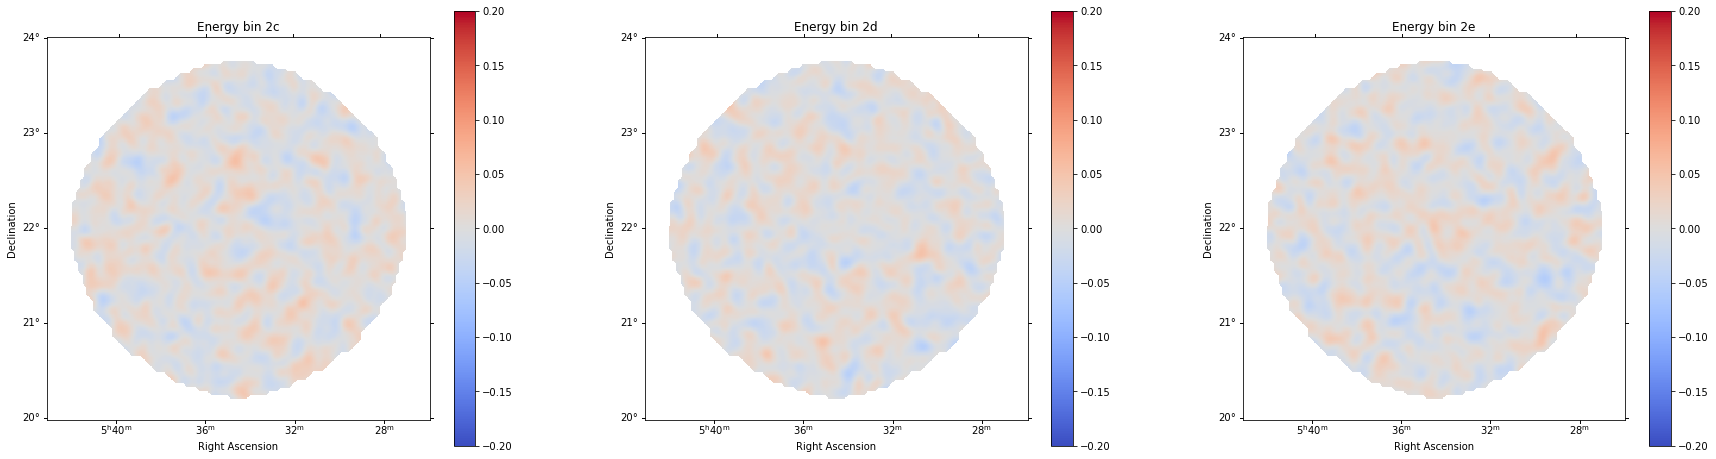

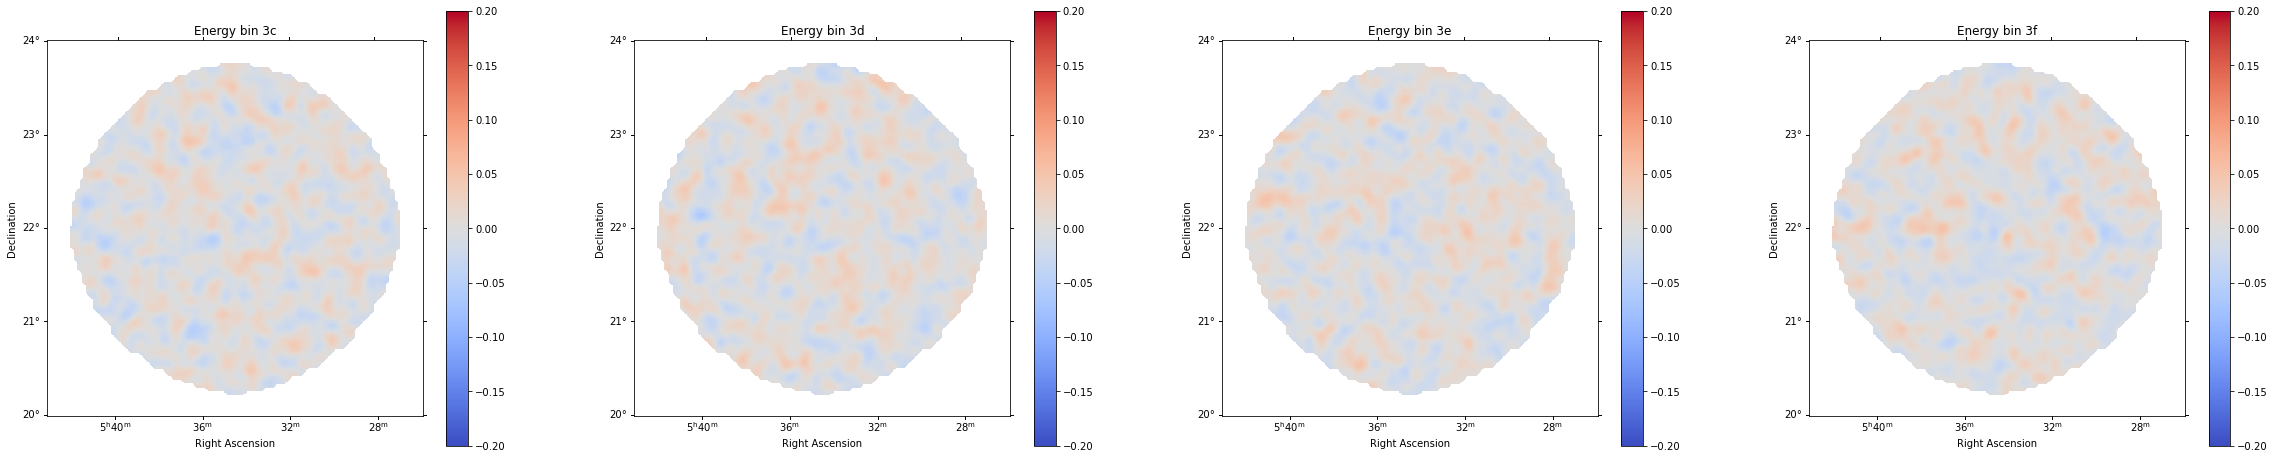

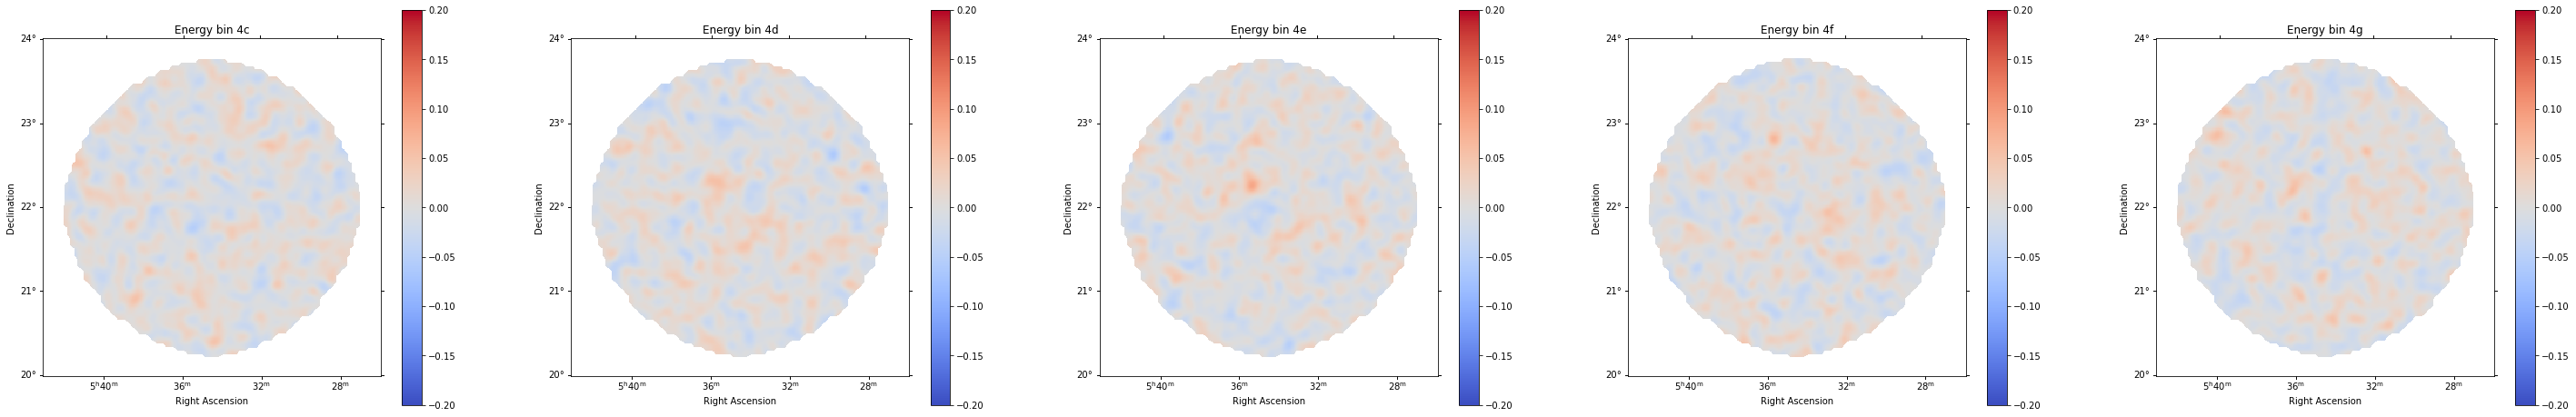

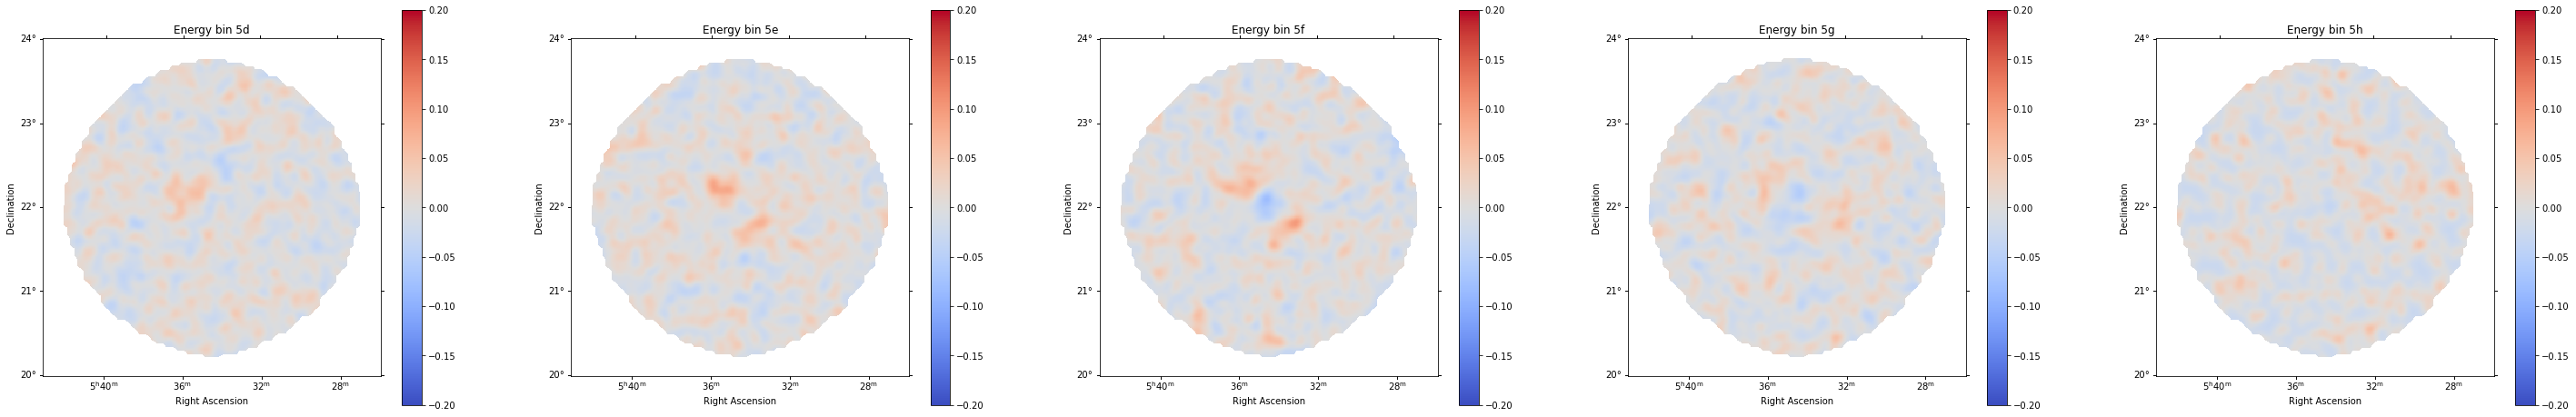

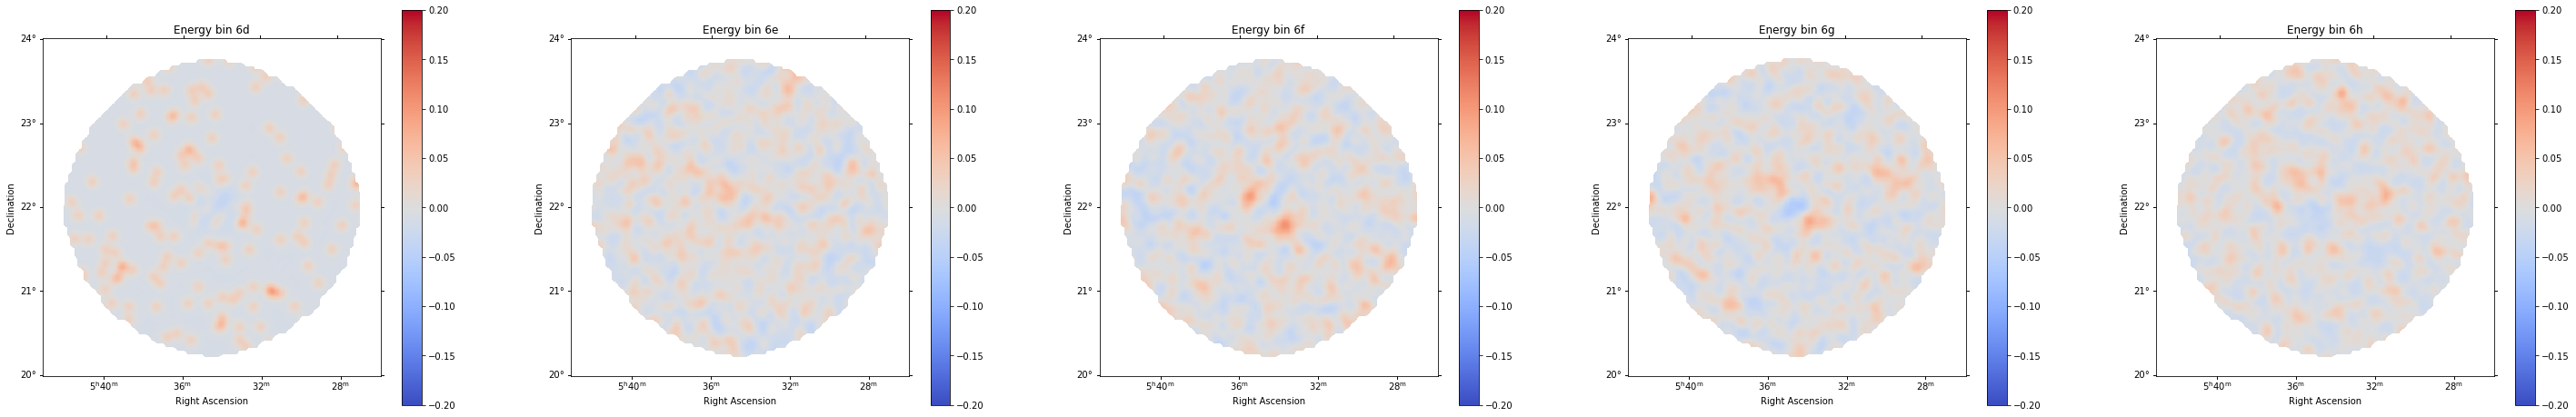

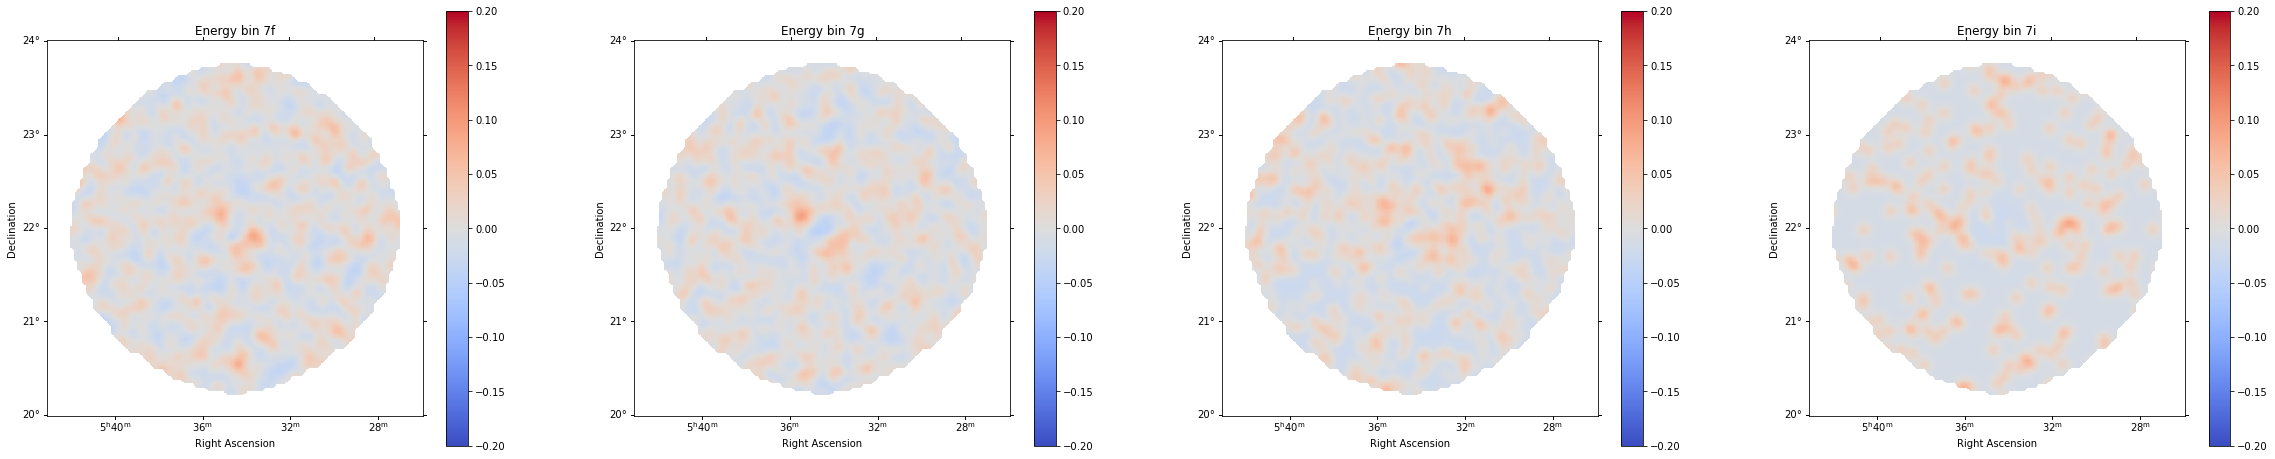

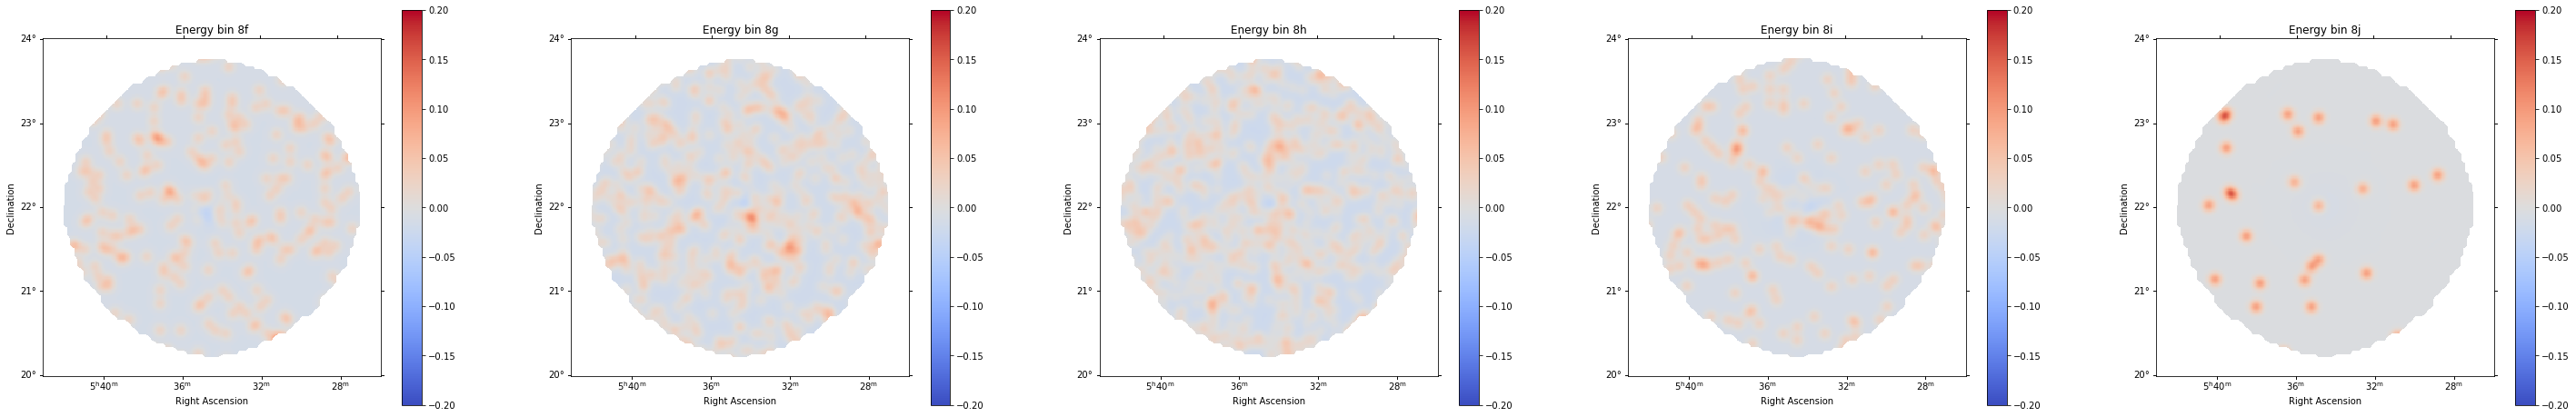

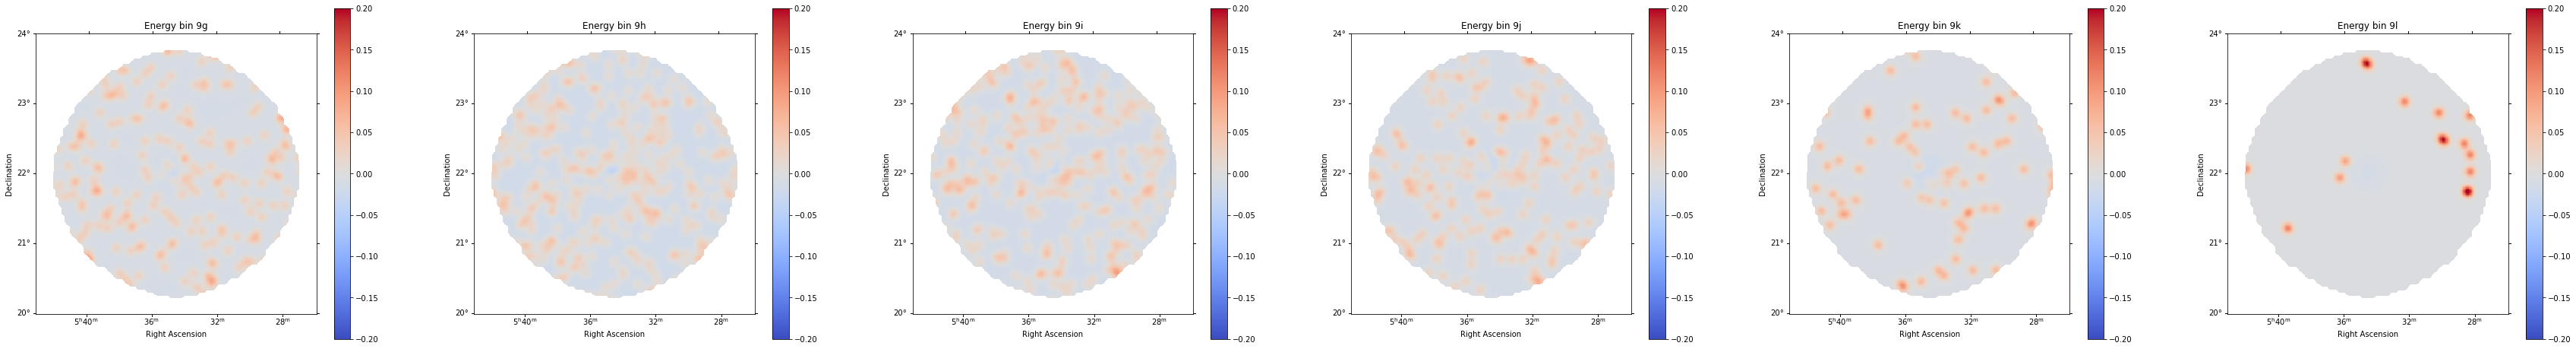

In [17]:
for i, residual in enumerate(residuals):
    plot_nhit_grid(
        residual.to_wcs().smooth("0.05 deg"),
        event_class=i,
        vmin=-0.2,
        vmax=0.2,
        cmap="coolwarm",
        stretch="linear",
        add_cbar=True
    )
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.savefig("plots/residual-significance-%dnhit.png"%(i+1), dpi=180, bbox_inches='tight')

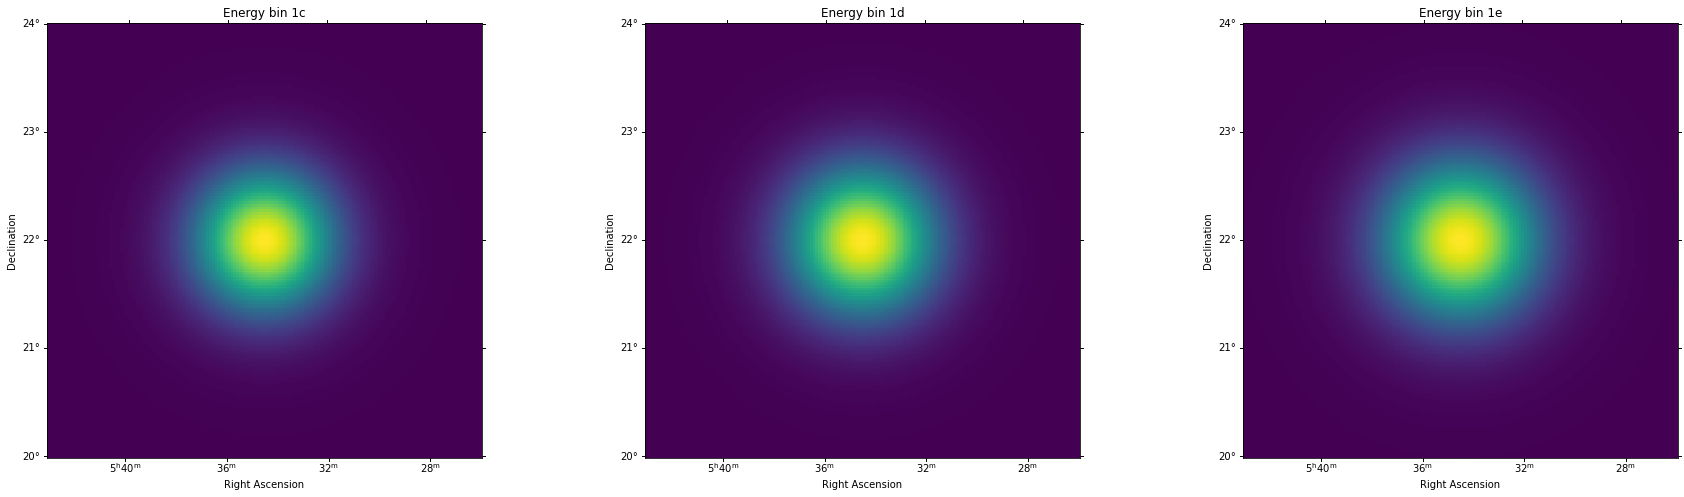

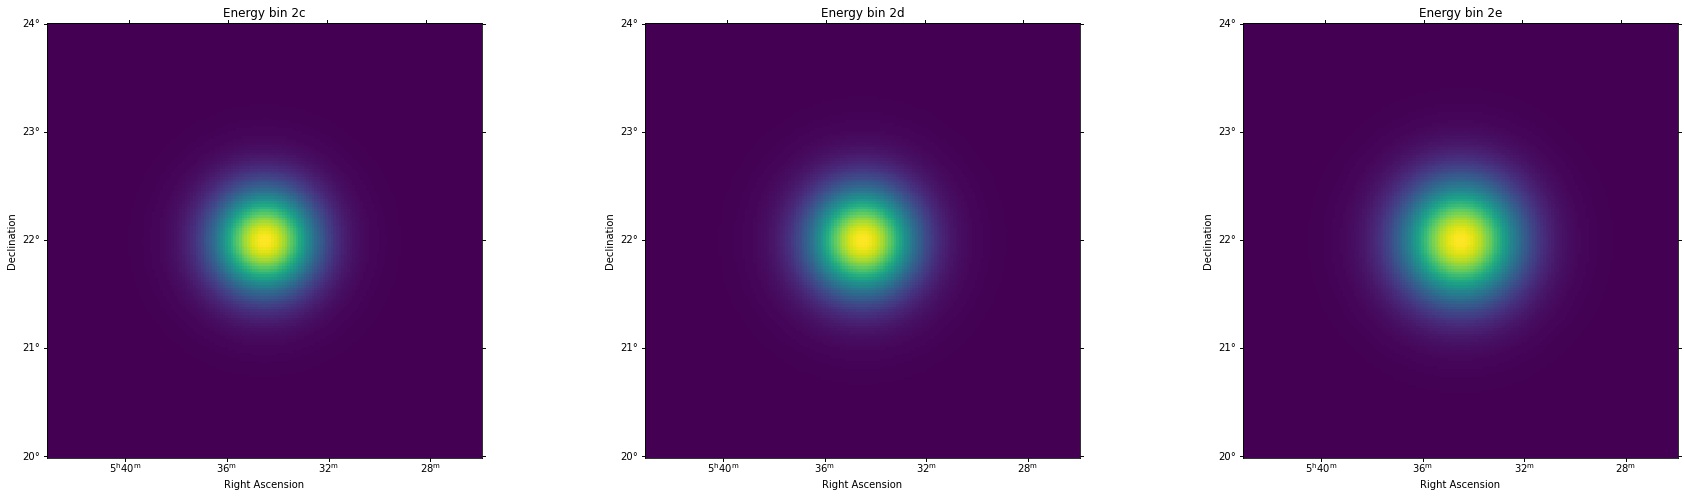

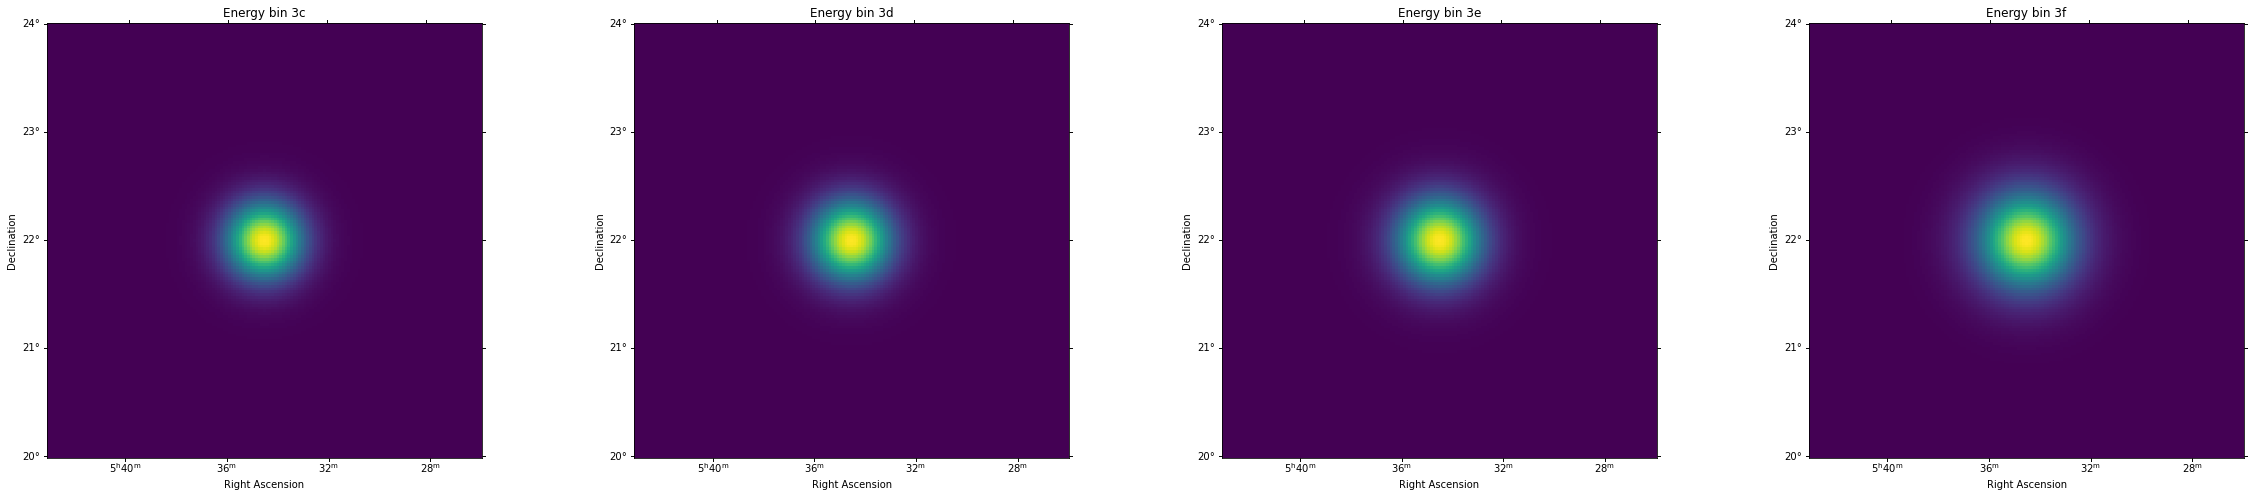

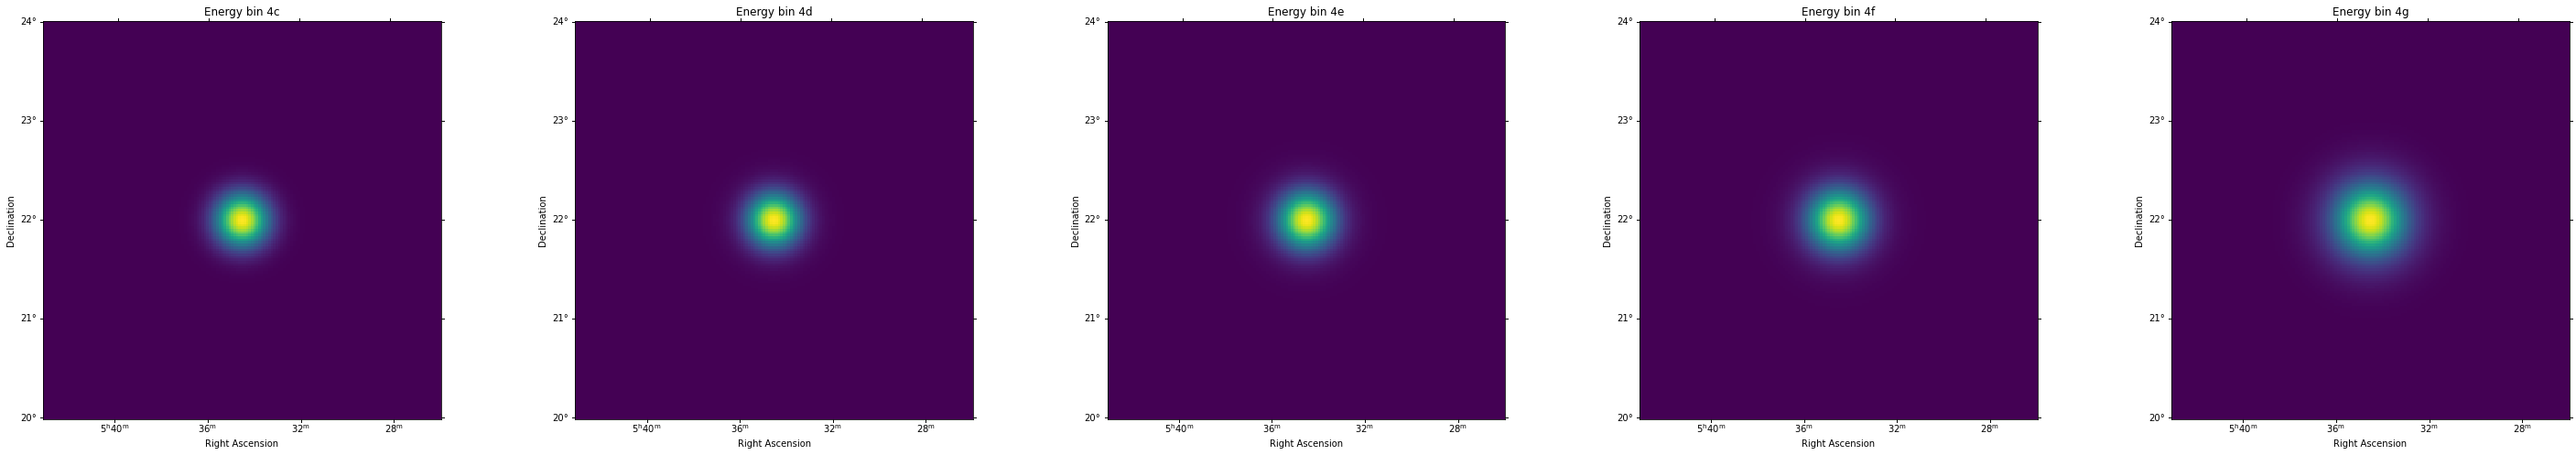

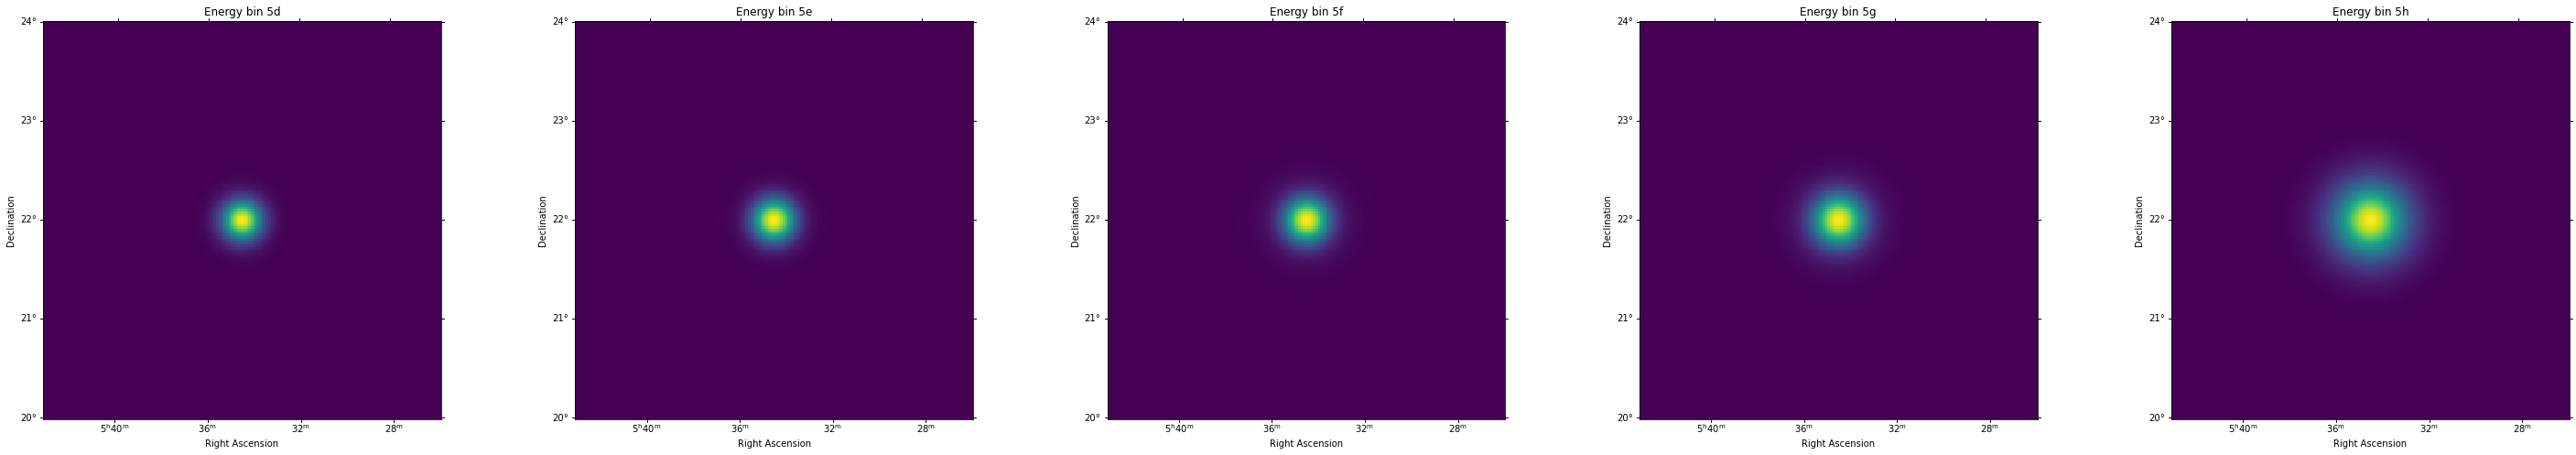

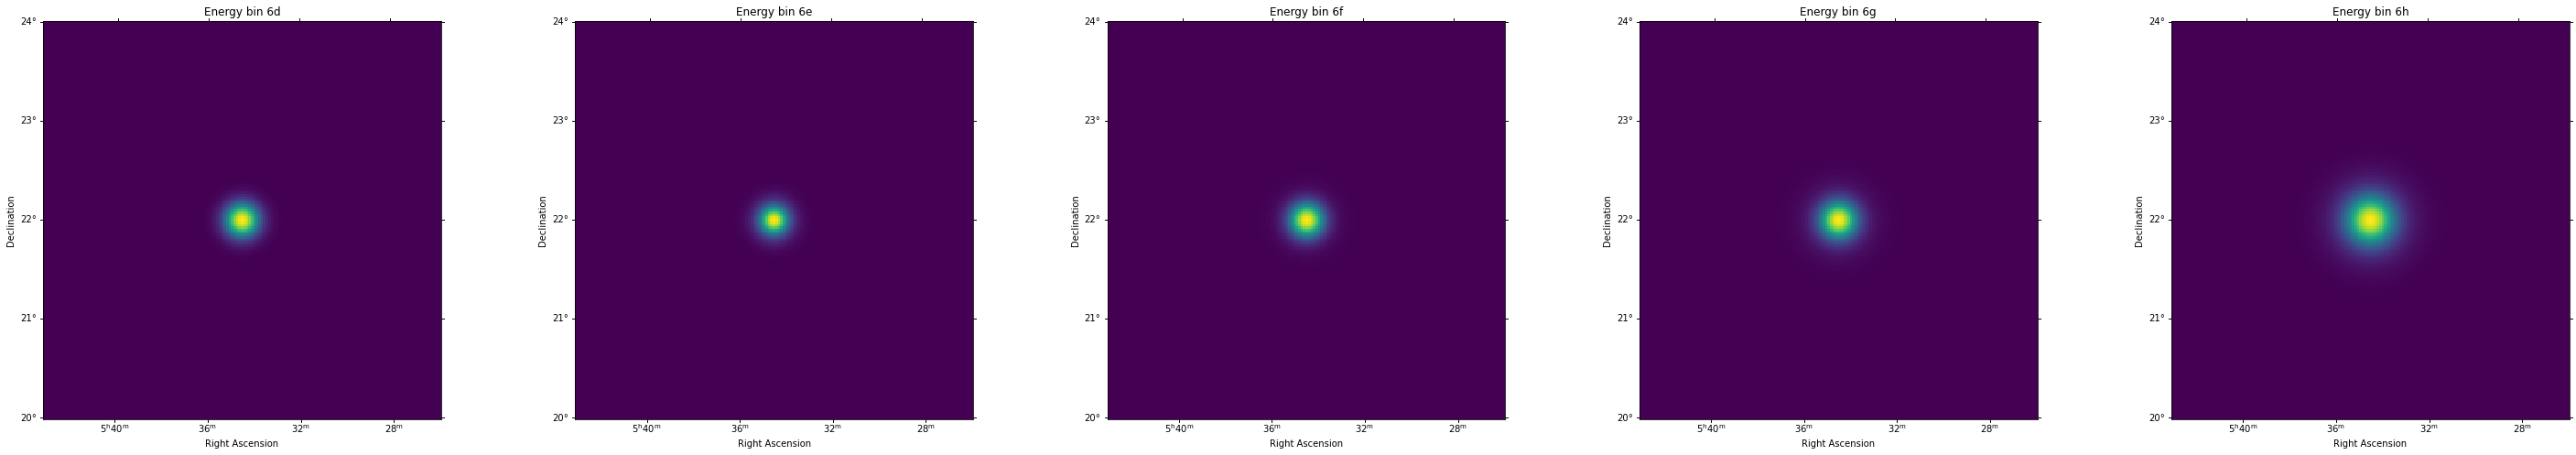

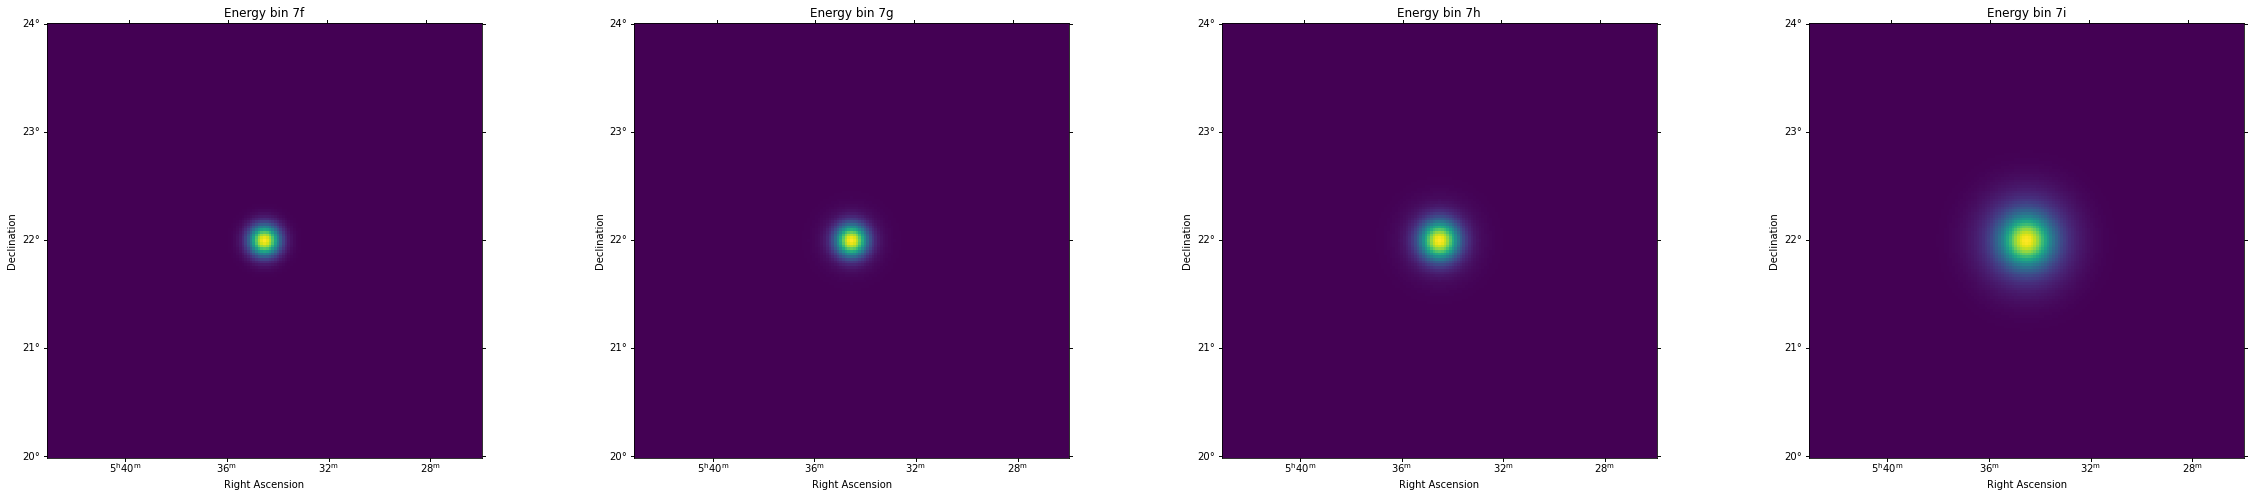

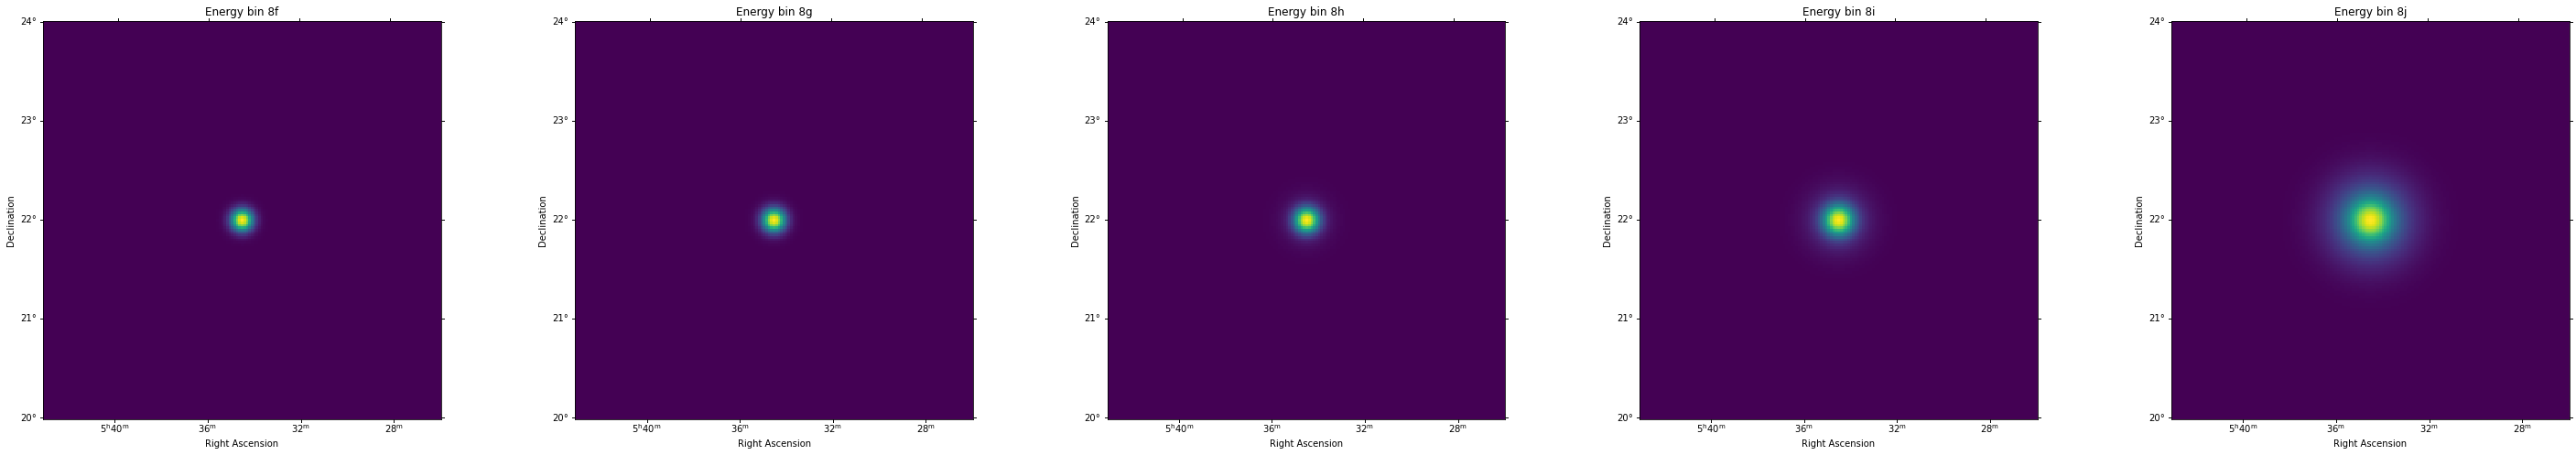

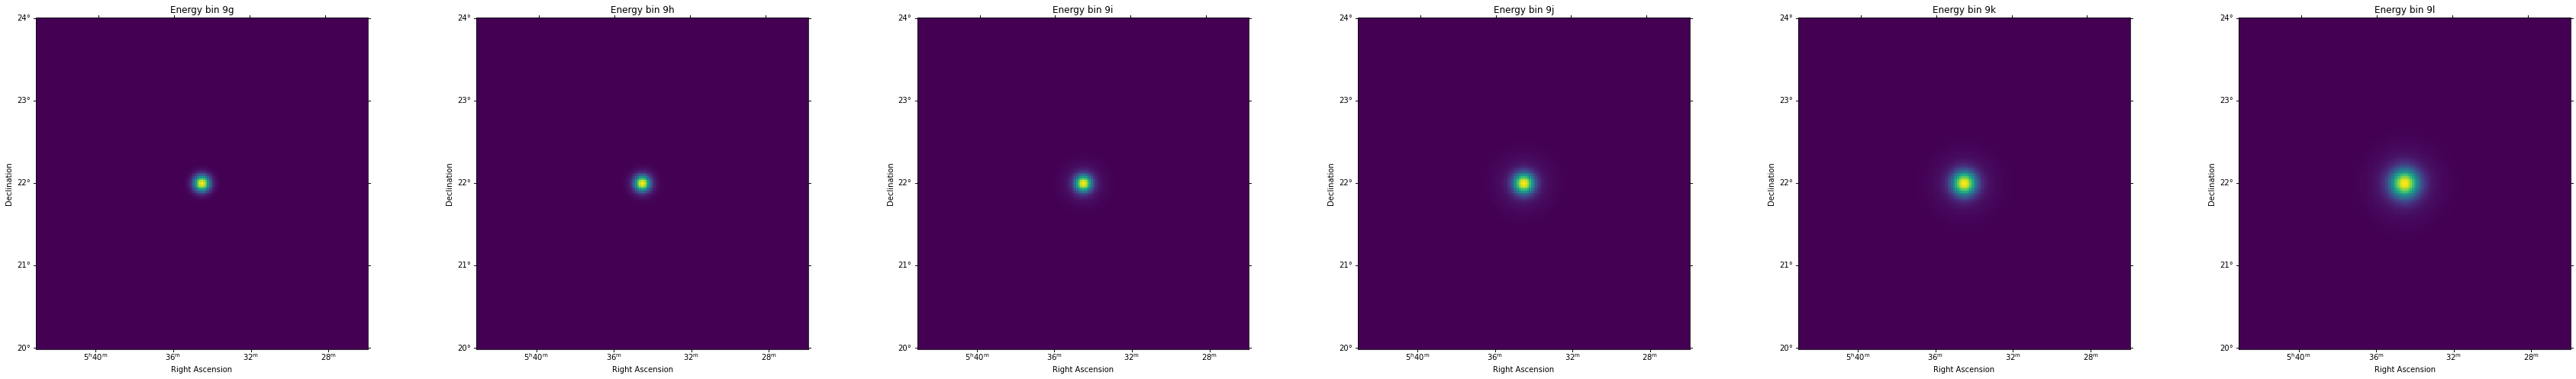

In [18]:
for i in range(9):
    plot_nhit_grid(hawc_datasets_nHitBin[i].psf.psf_kernel_map, event_class = i, cmap="viridis")
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.savefig("plots/psf-%dnhit.png"%(i+1), dpi=180, bbox_inches='tight')

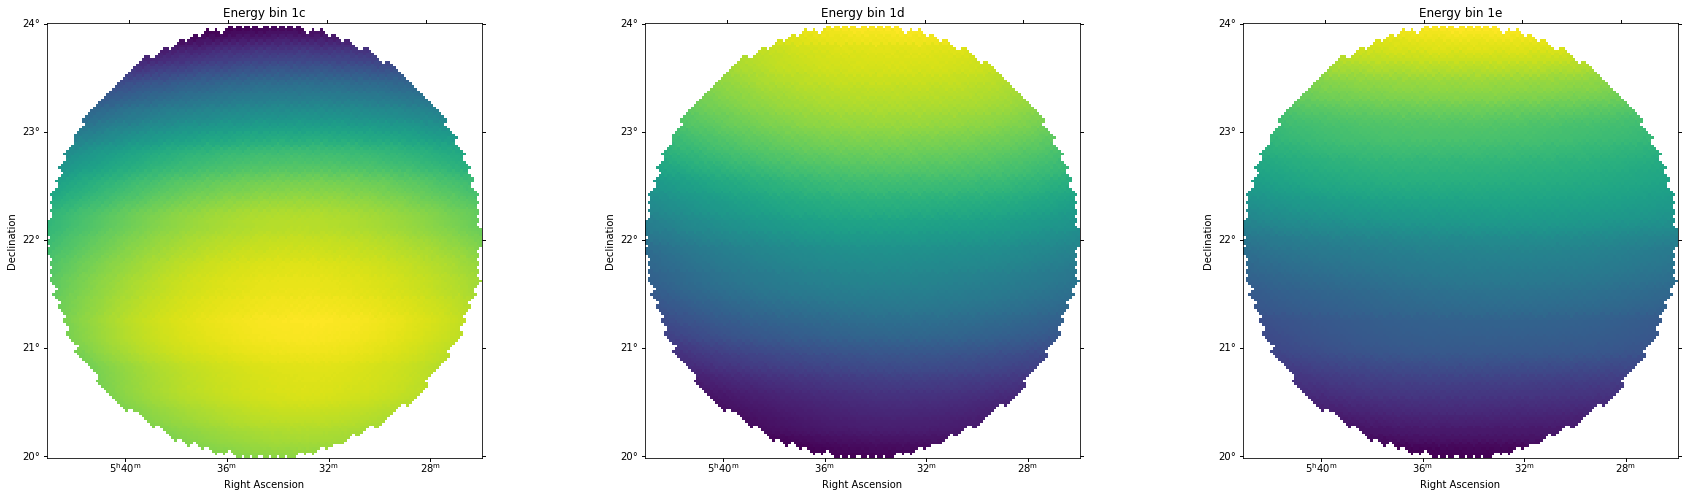

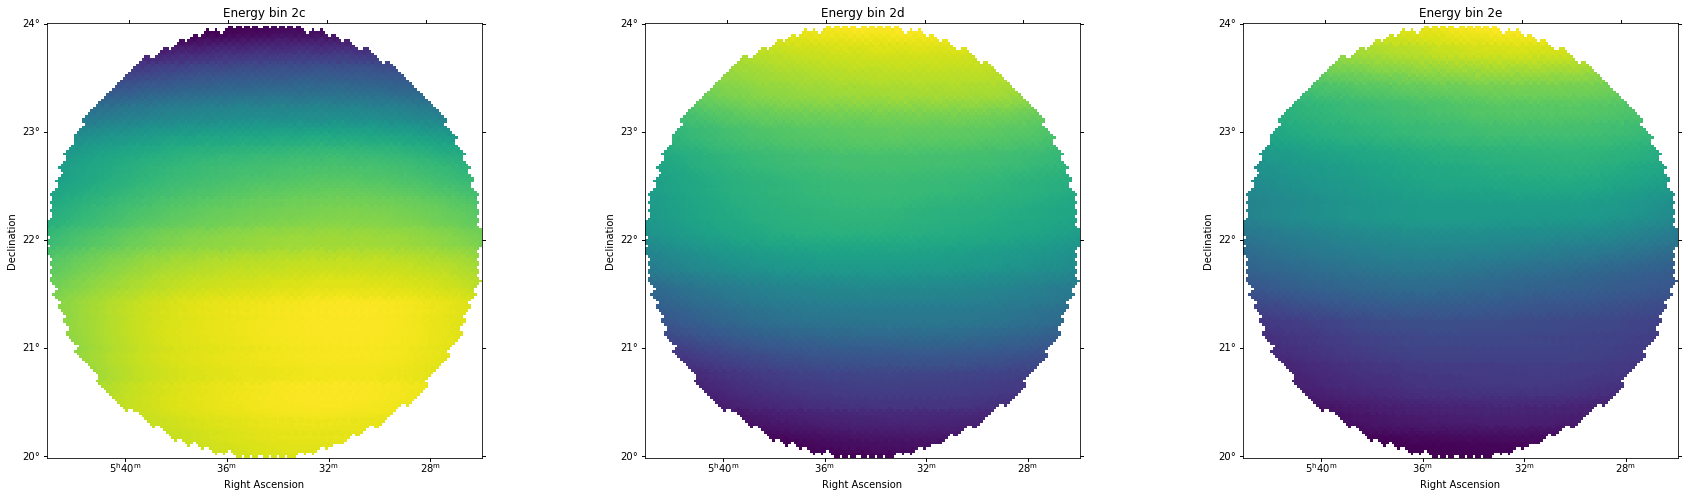

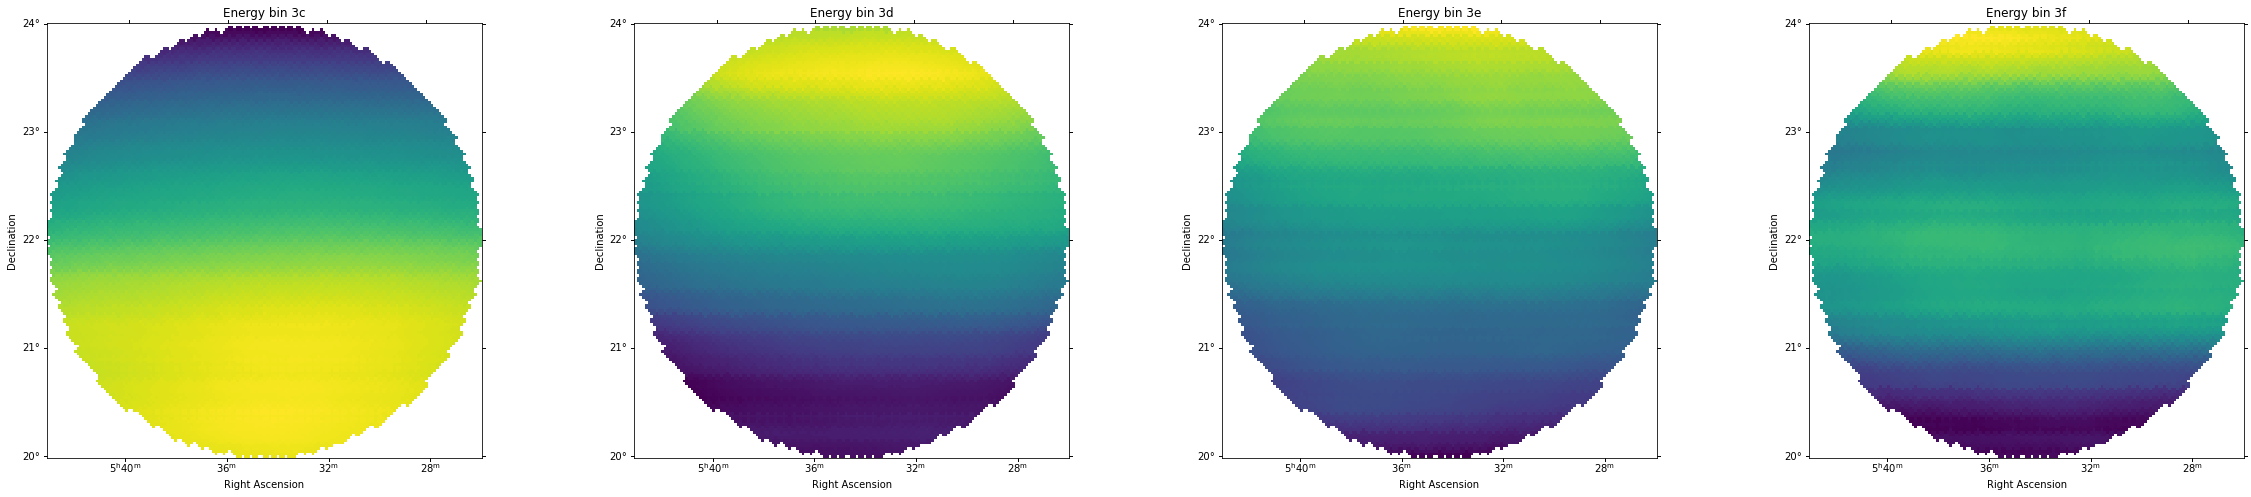

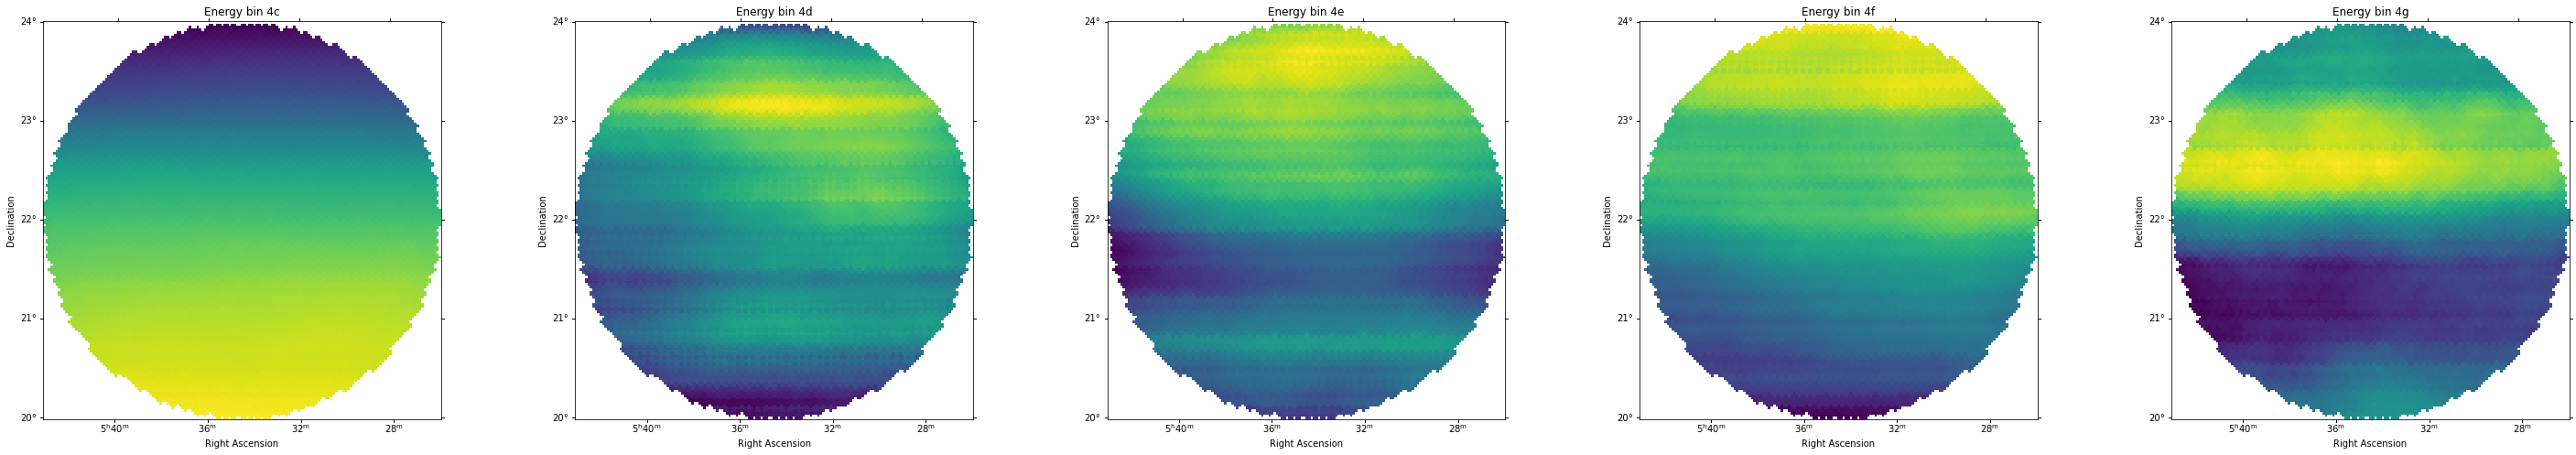

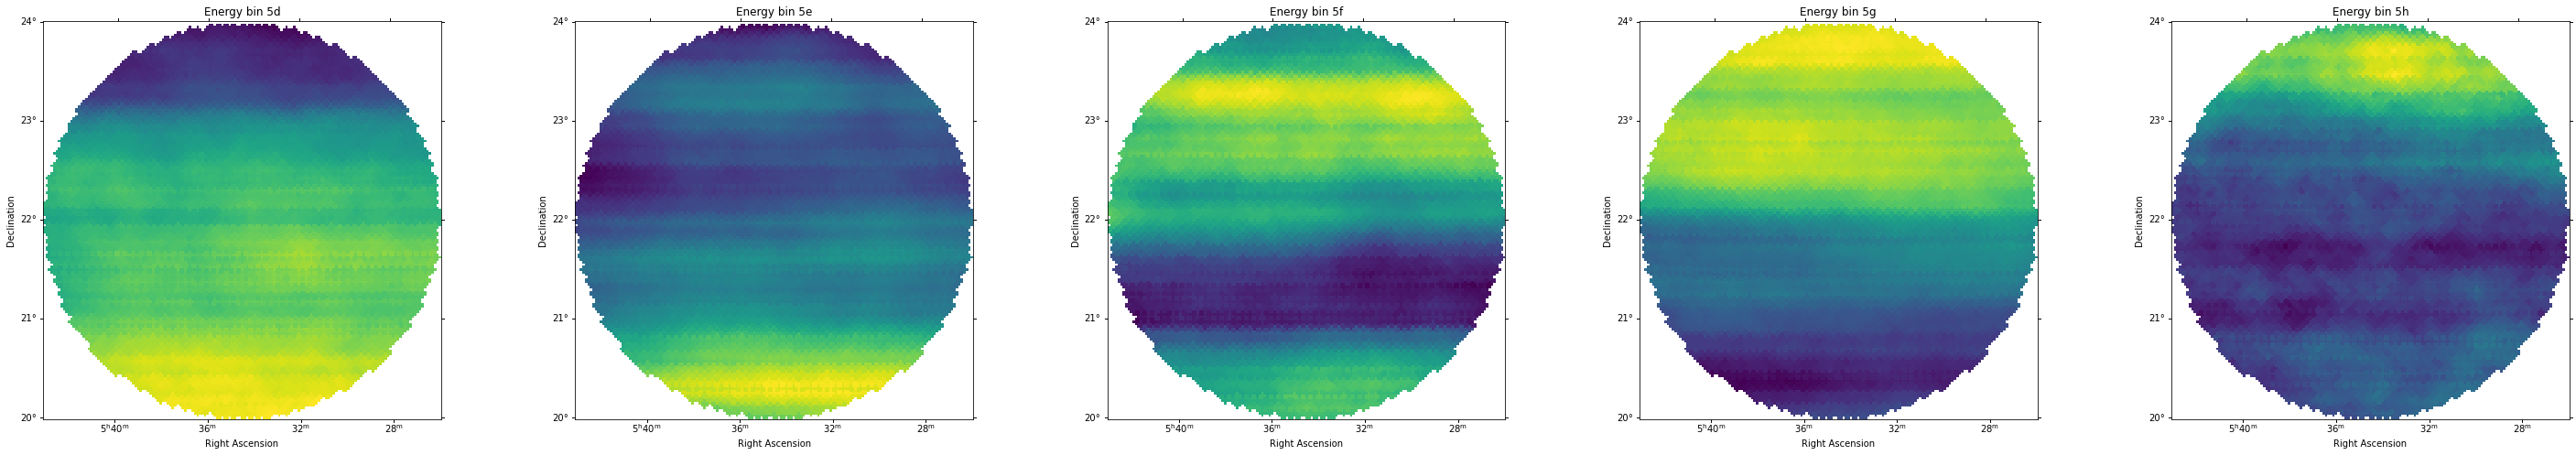

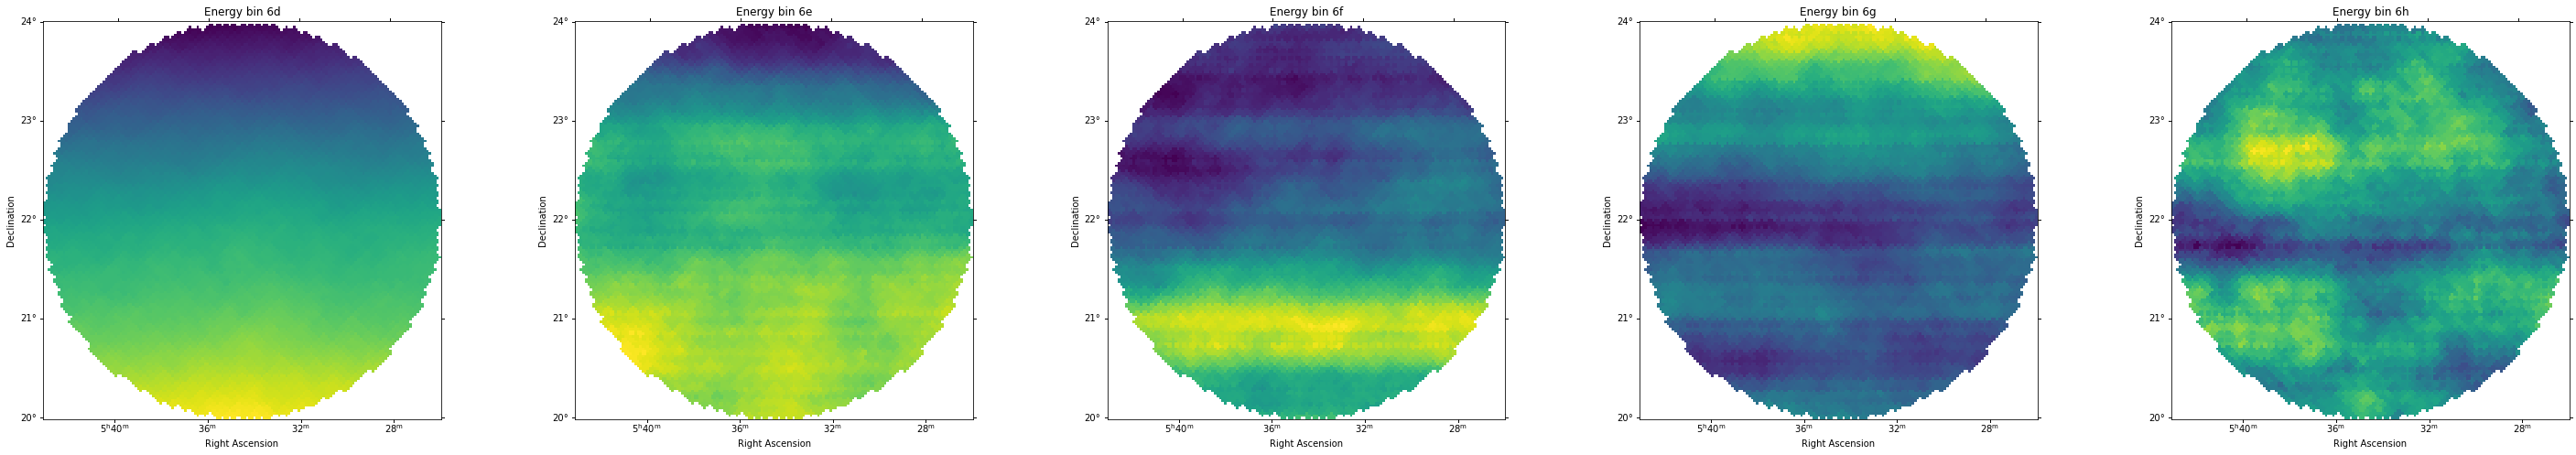

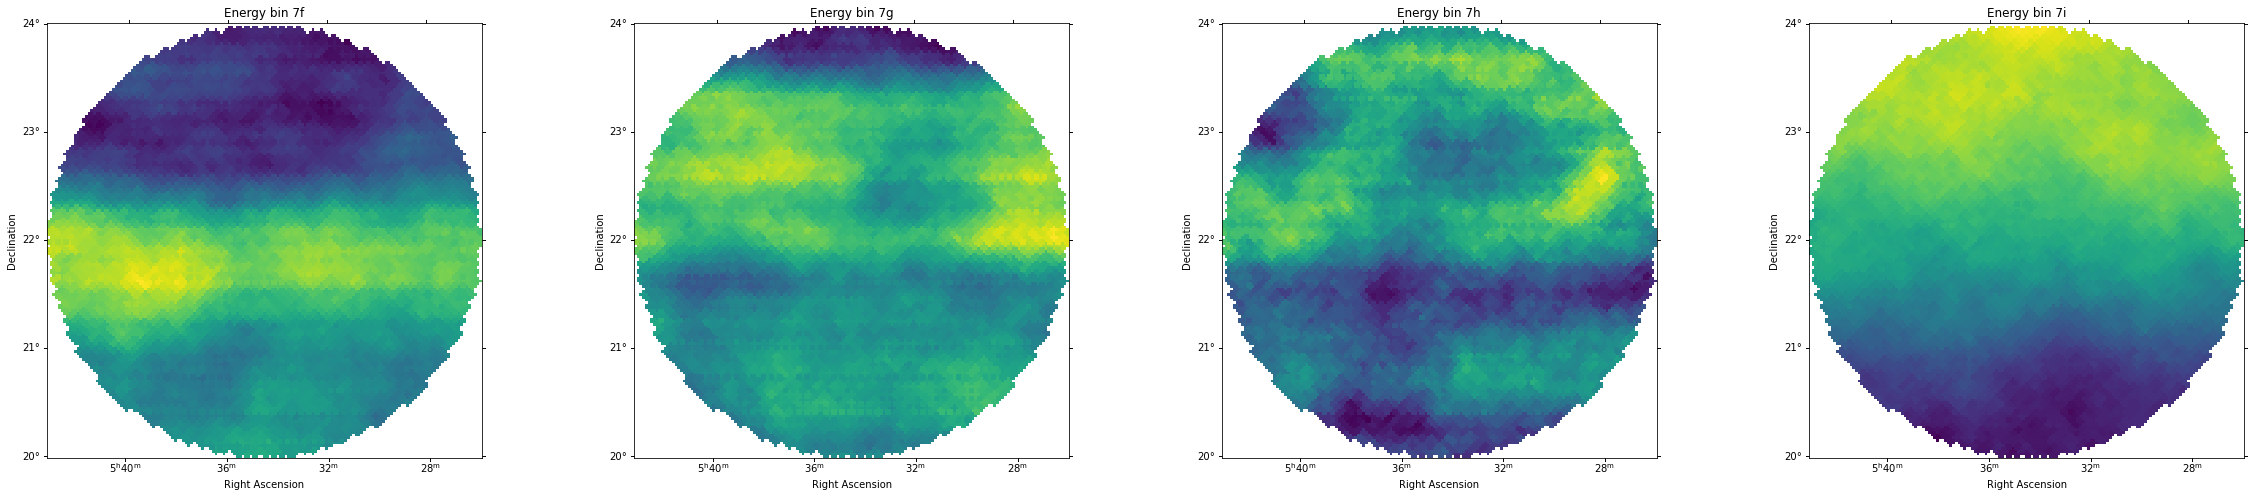

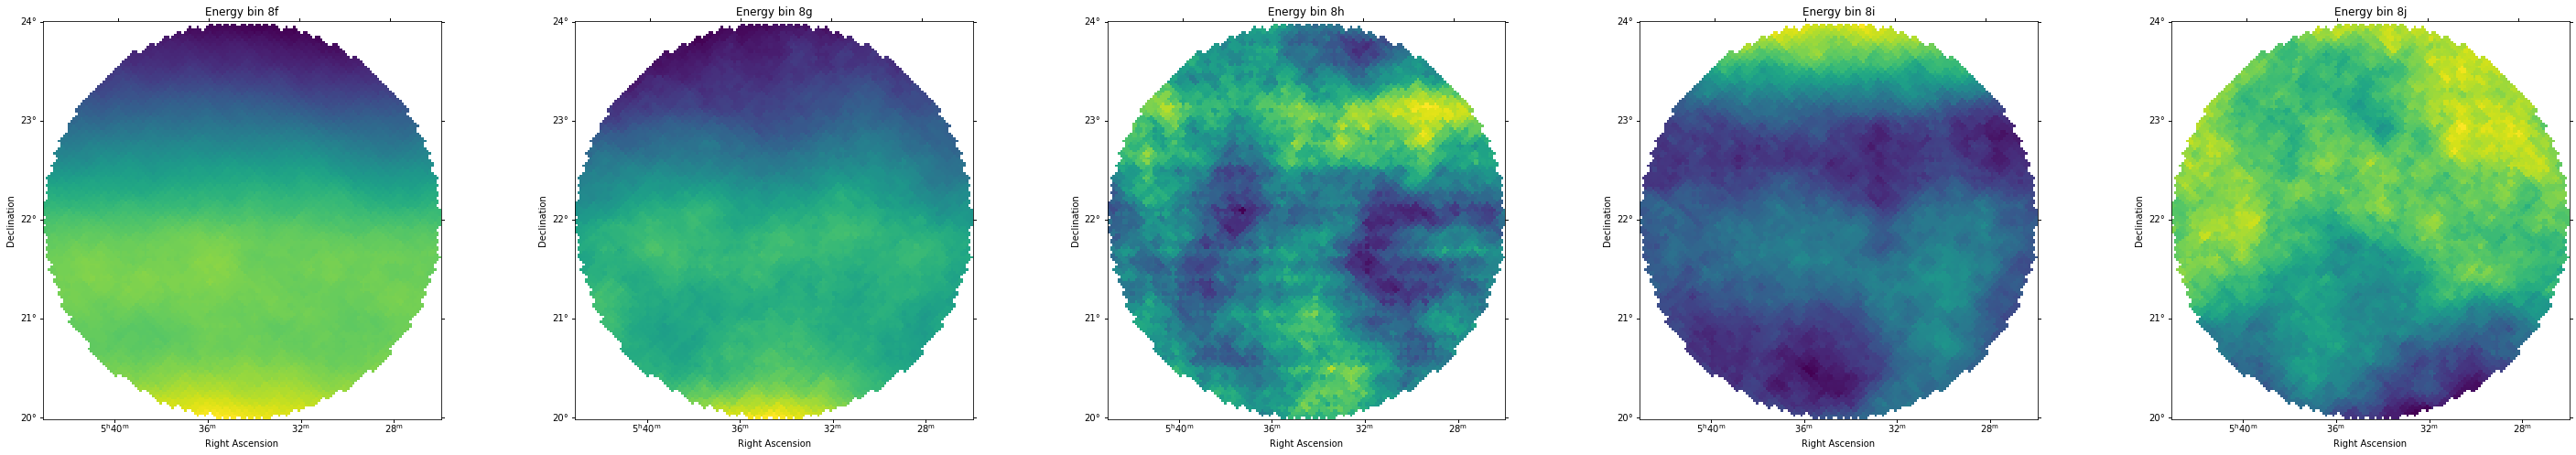

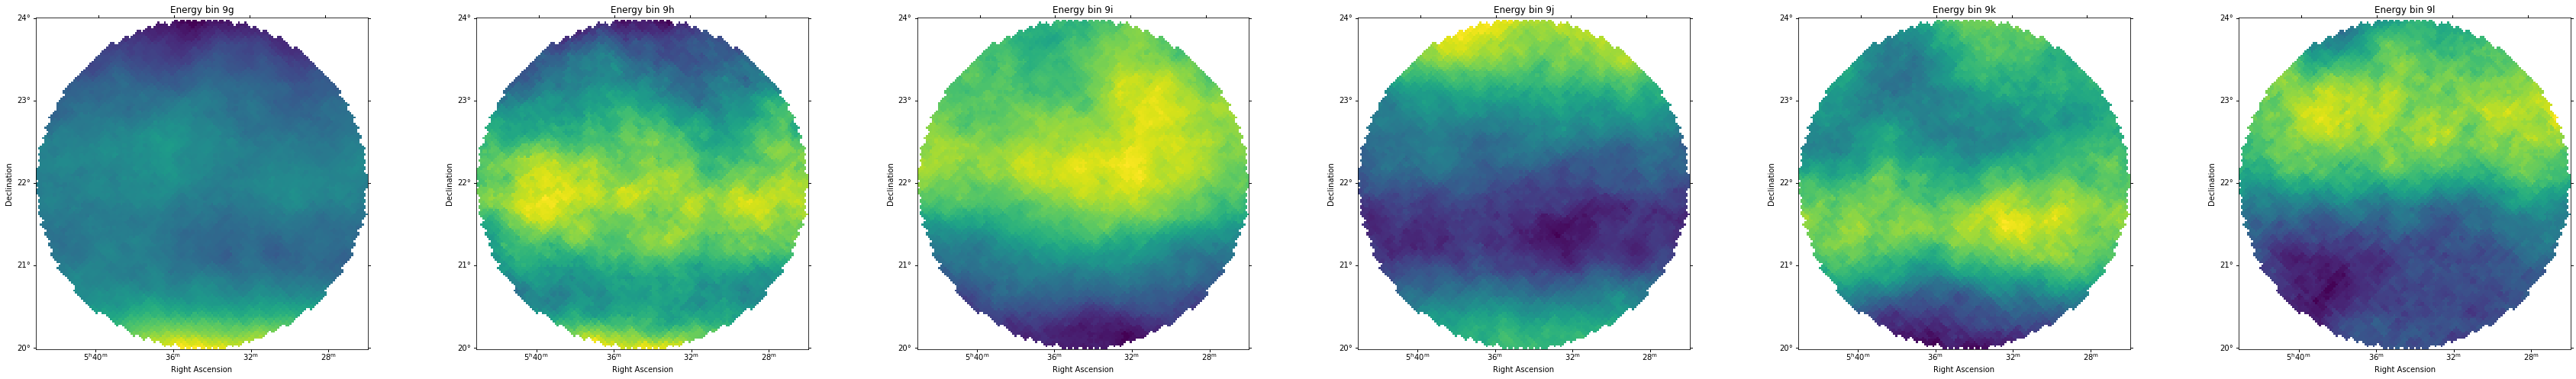

In [19]:
for i in range(9):
    plot_nhit_grid(hawc_datasets_nHitBin[i].background_model.map, event_class = i, cmap="viridis")
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.savefig("plots/bg-%dnhit.png"%(i+1), dpi=180, bbox_inches='tight')

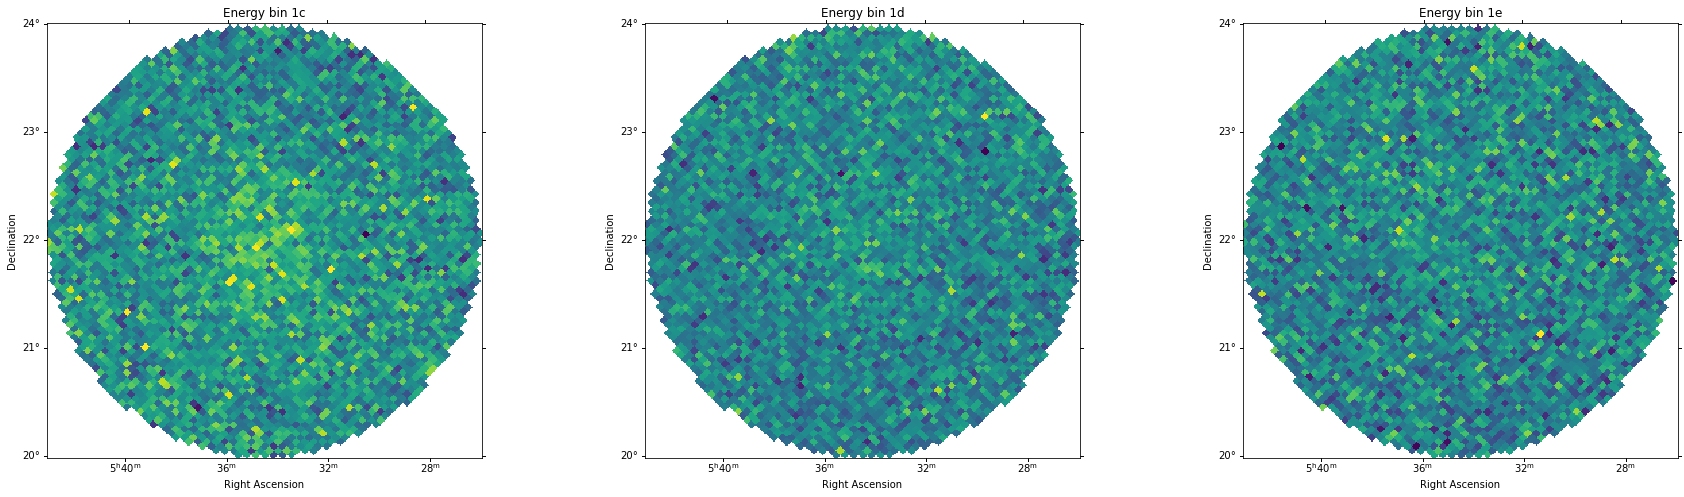

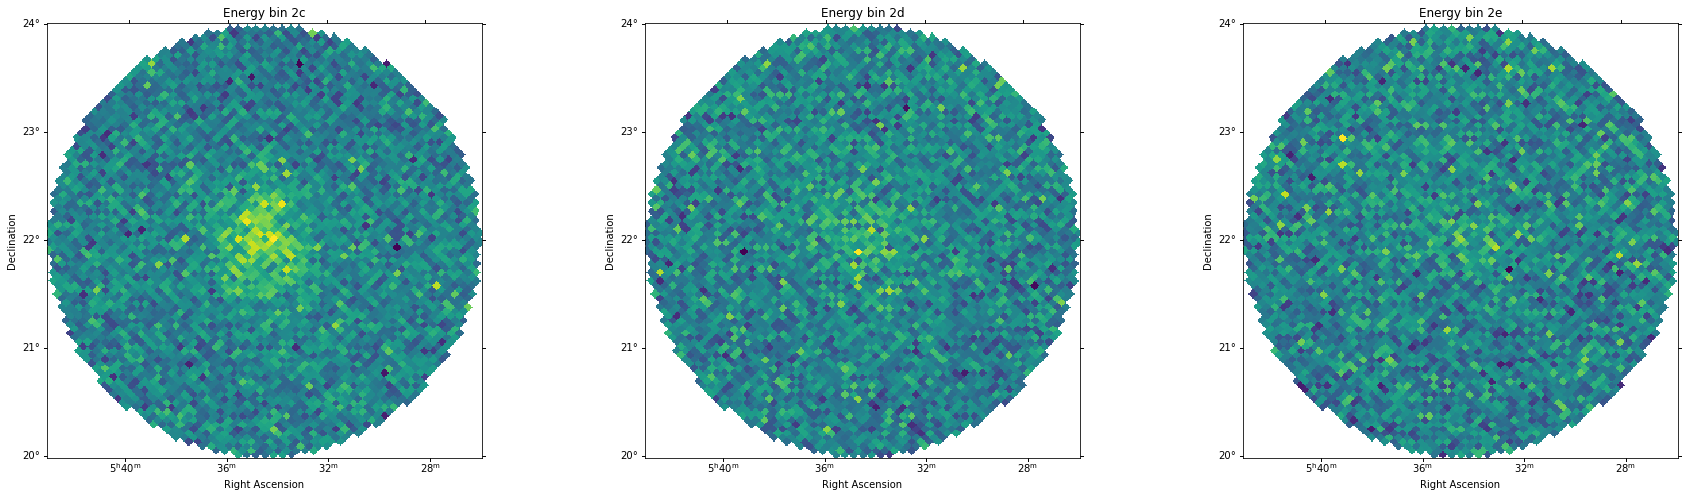

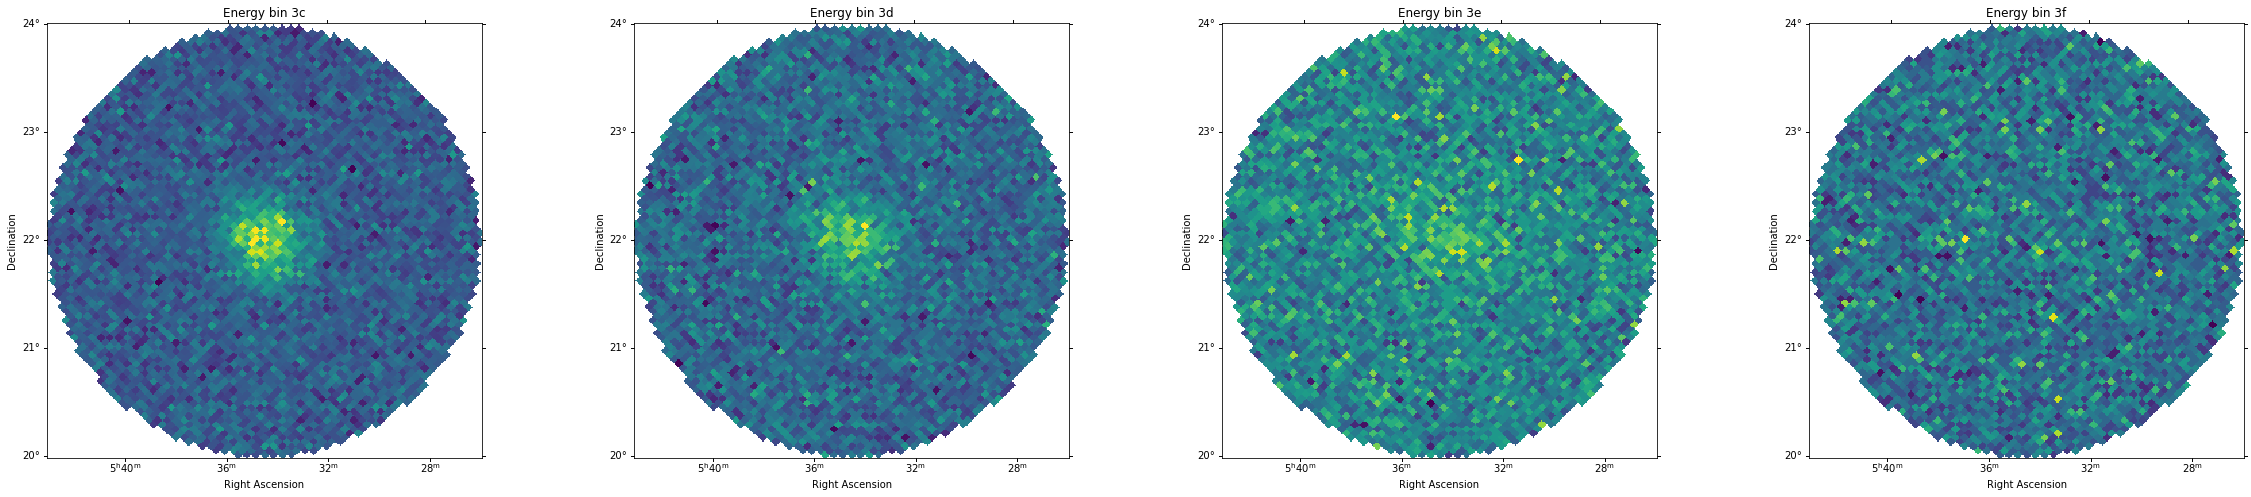

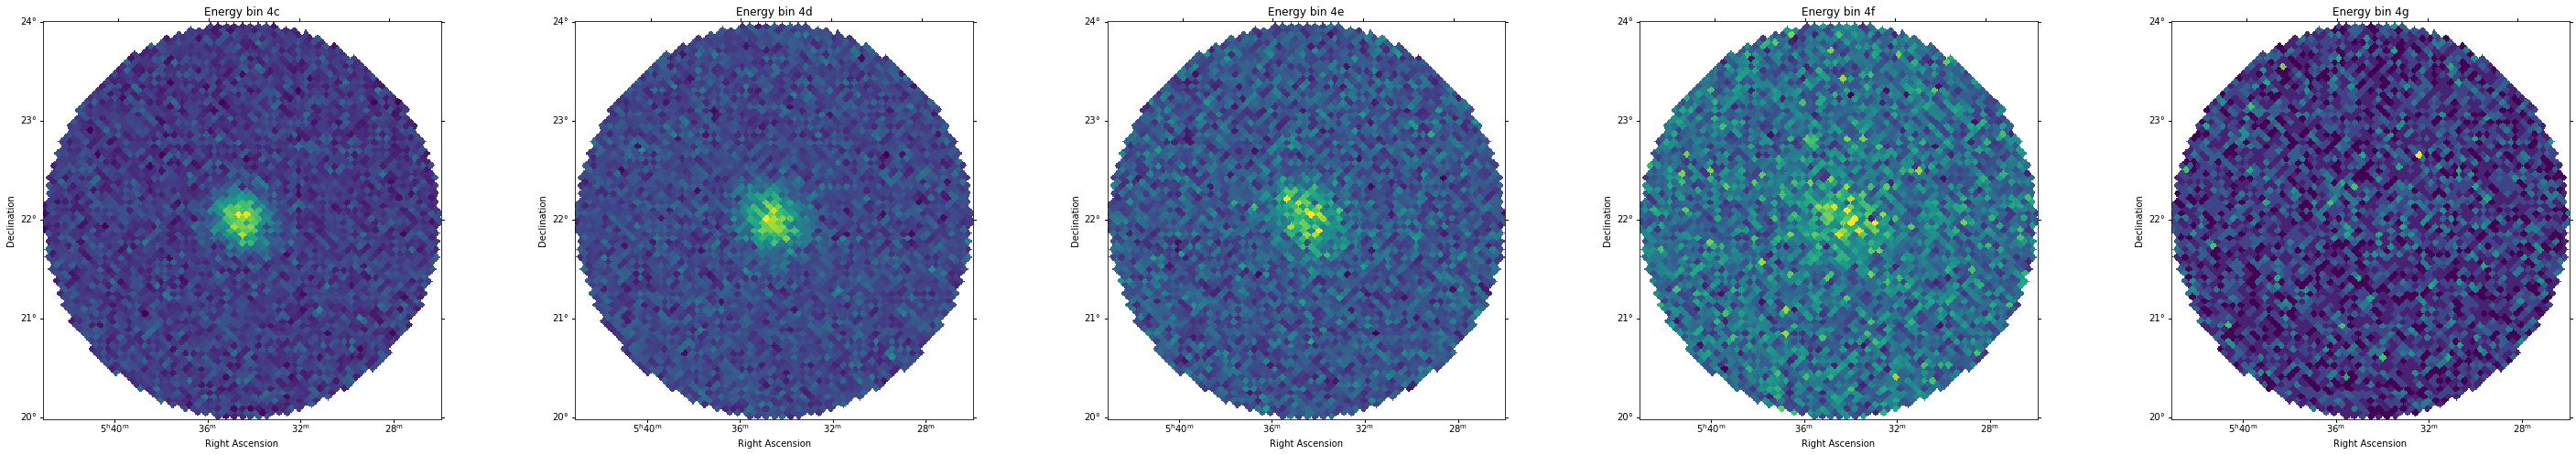

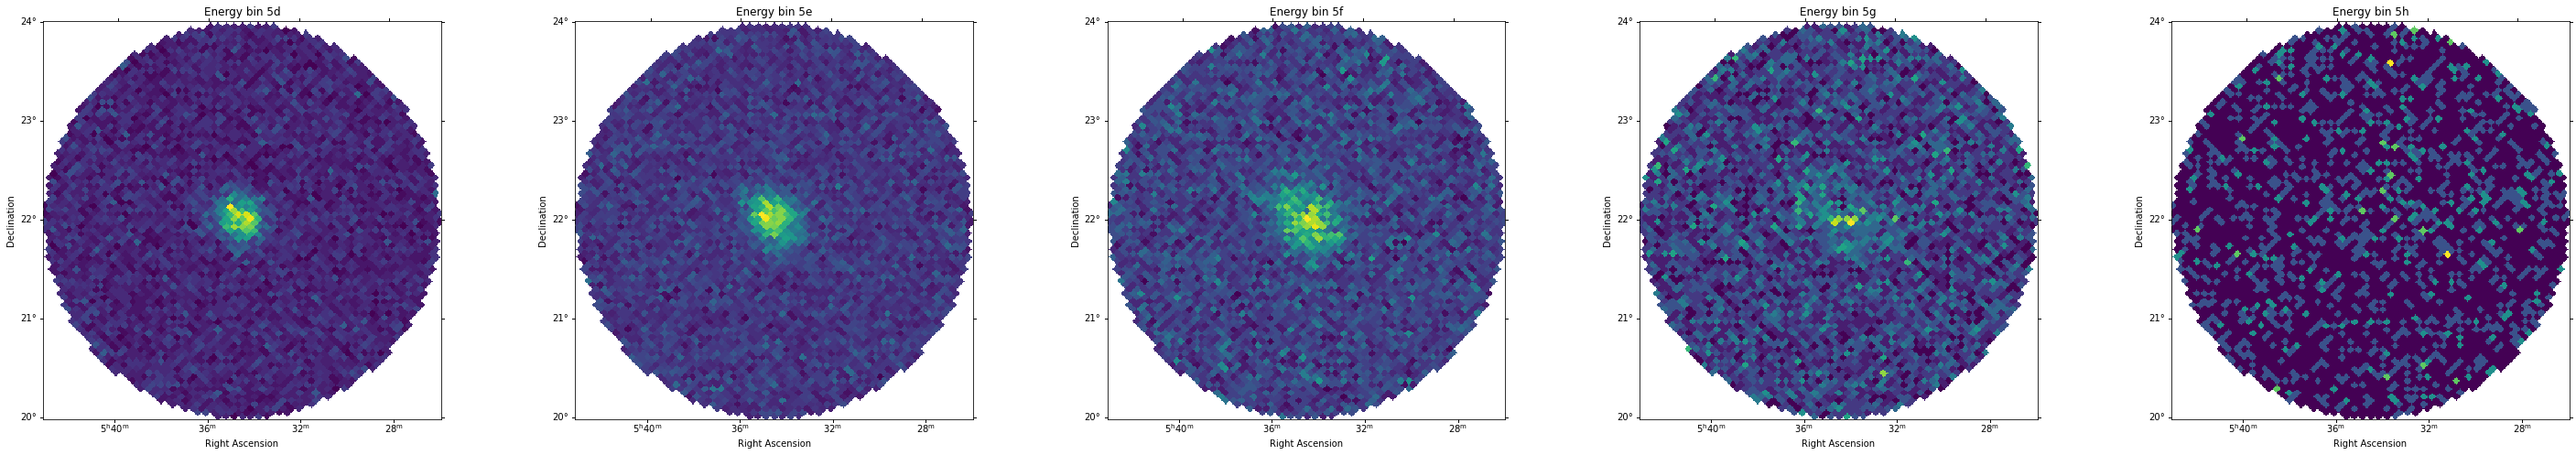

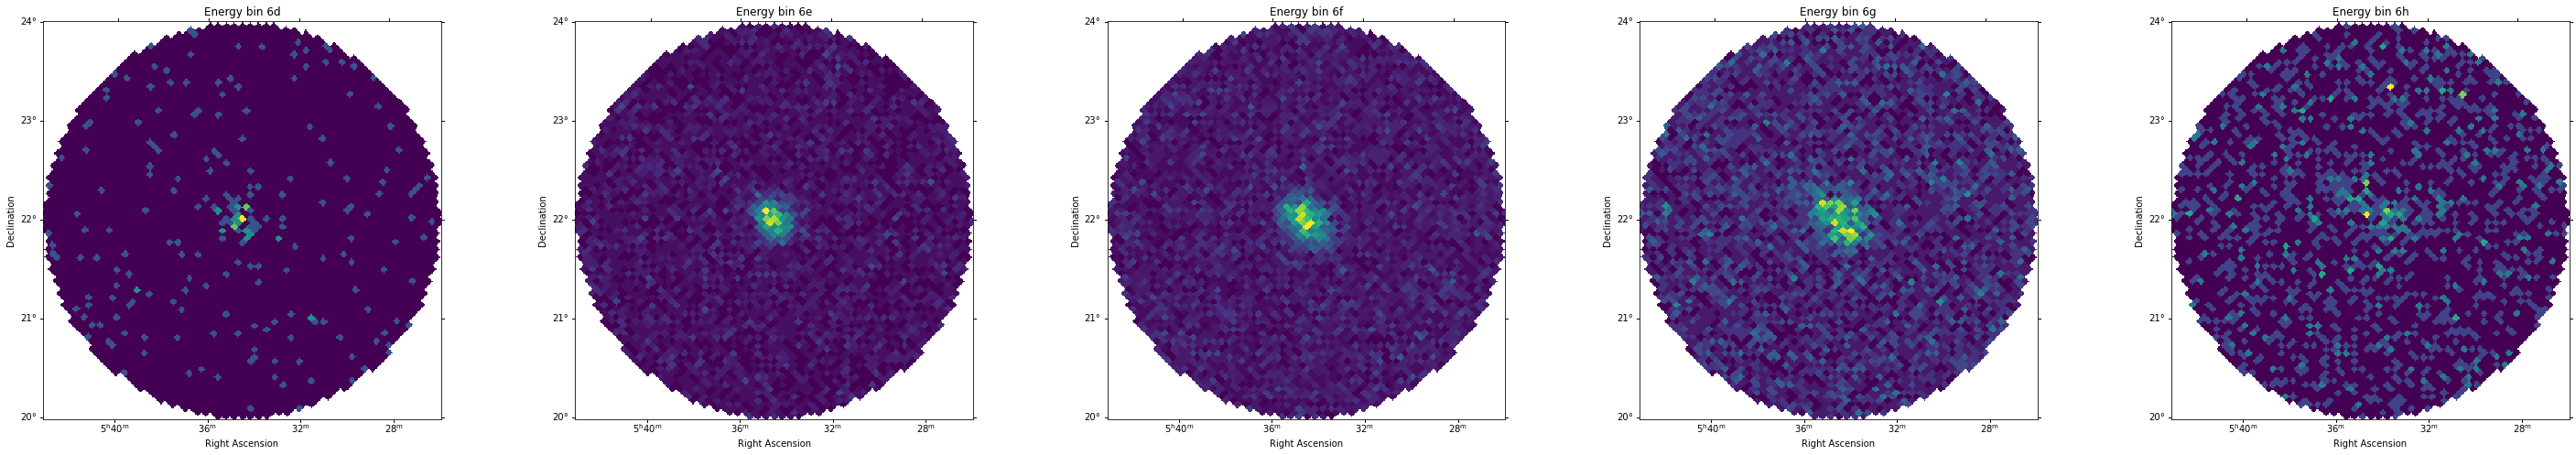

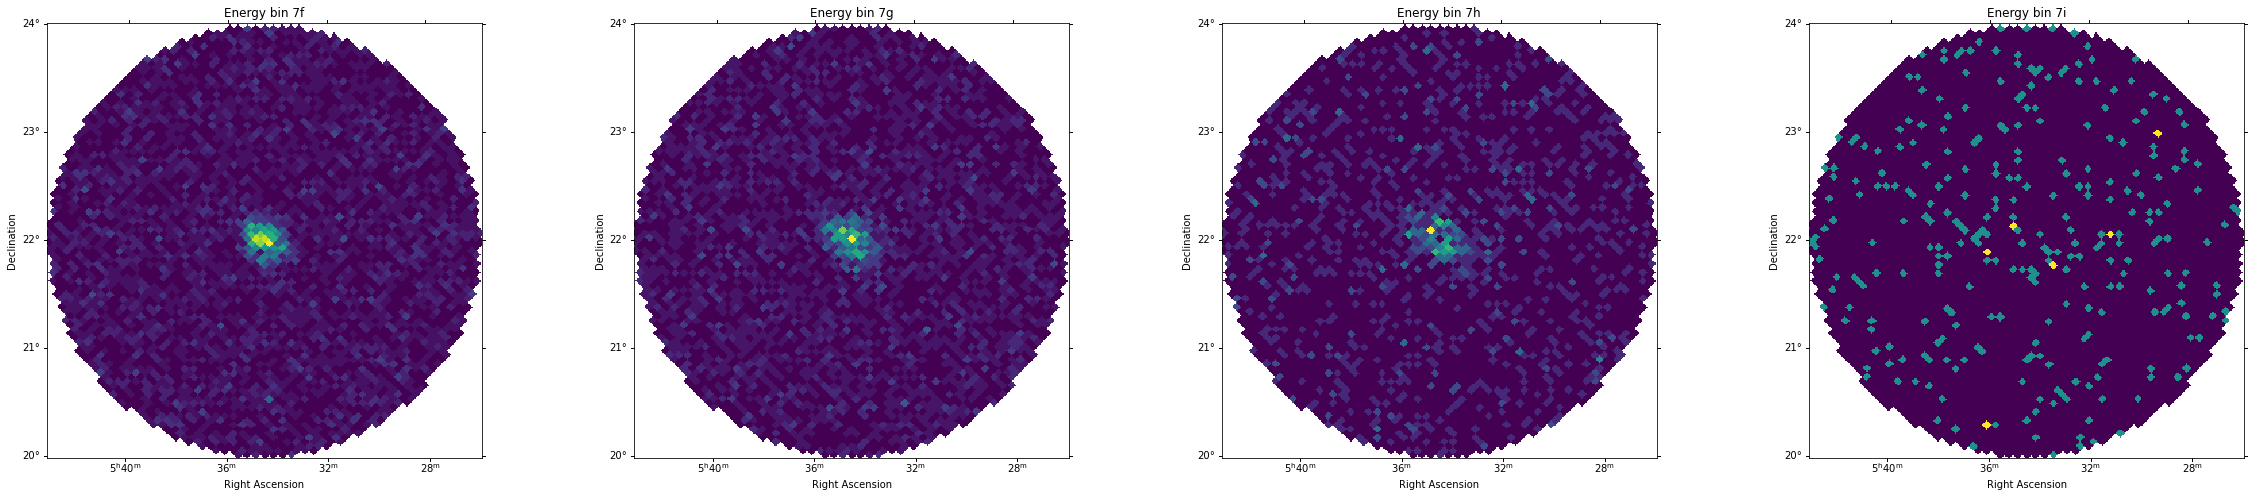

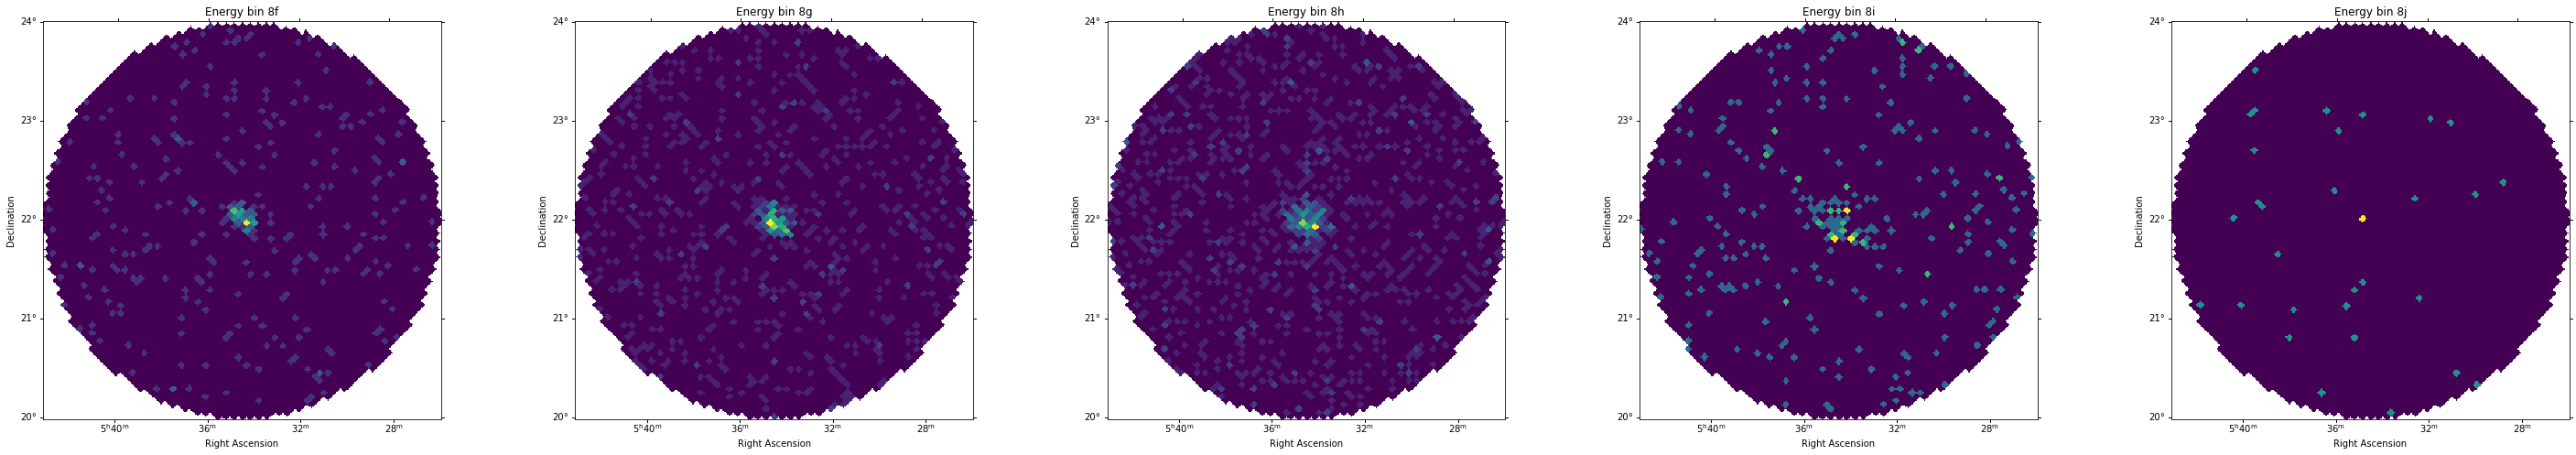

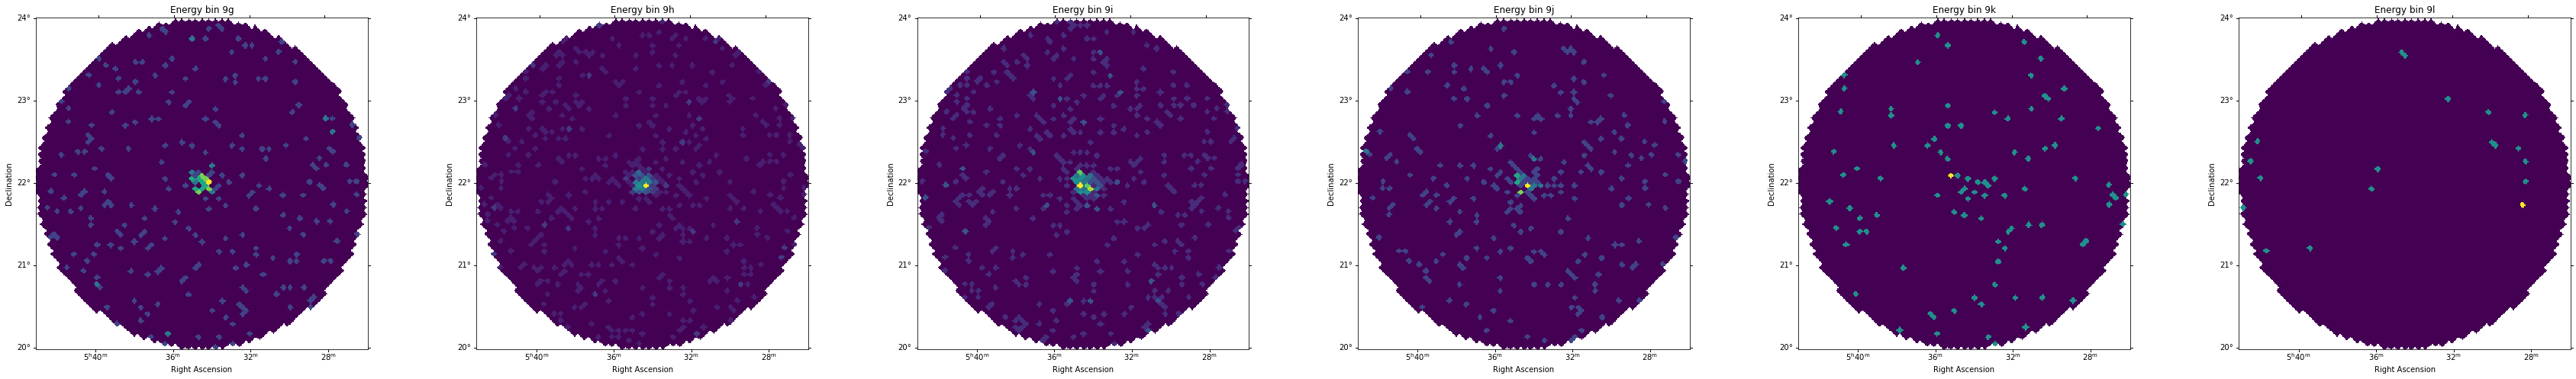

In [20]:
for i in range(9):
    plot_nhit_grid(hawc_datasets_nHitBin[i].counts, event_class = i, cmap="viridis")
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.savefig("plots/counts-%dnhit.png"%(i+1), dpi=180, bbox_inches='tight')

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: inval

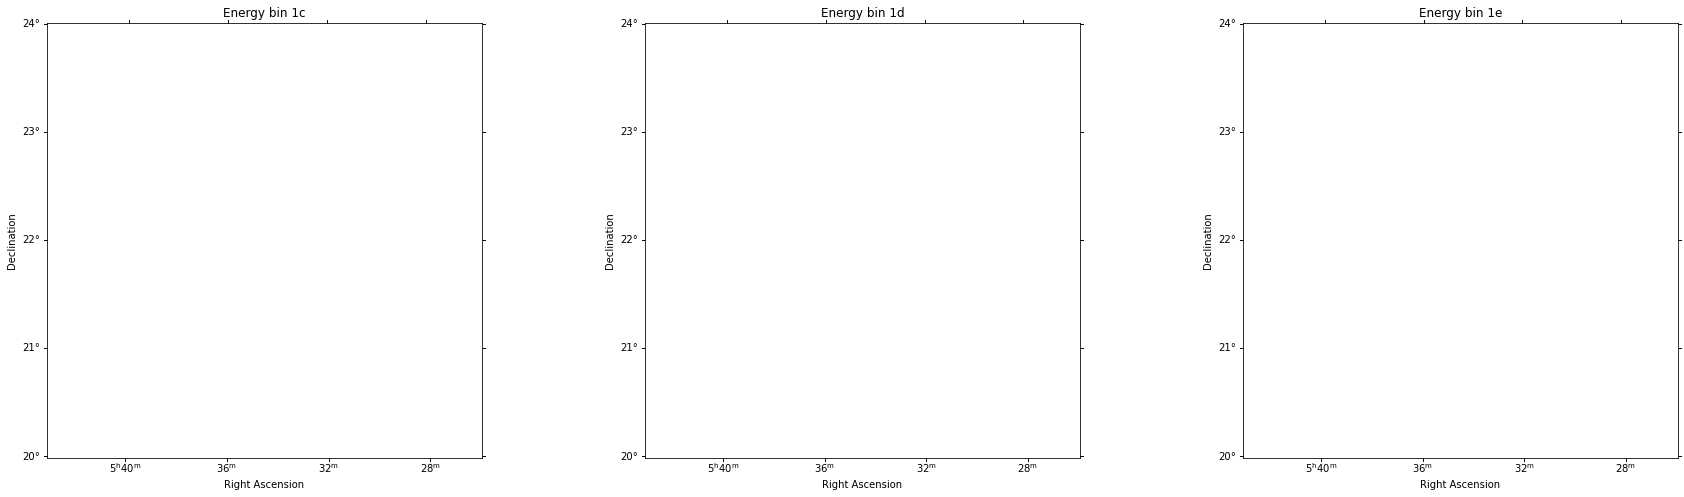

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: inval

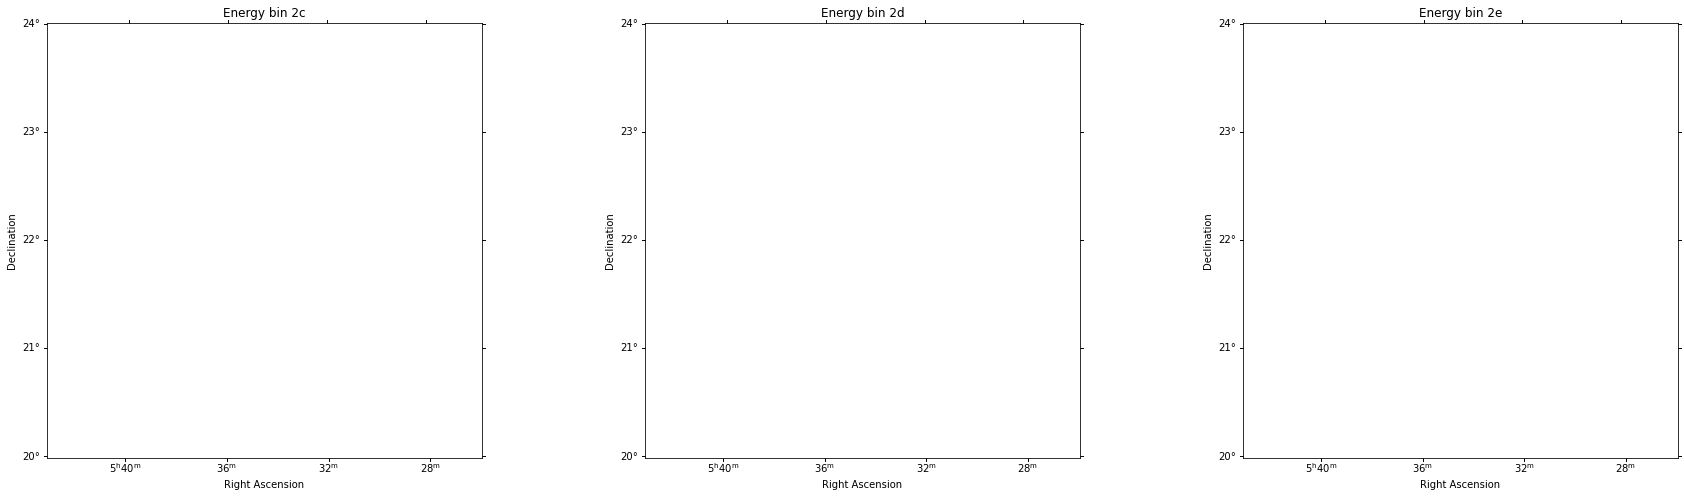

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: inval

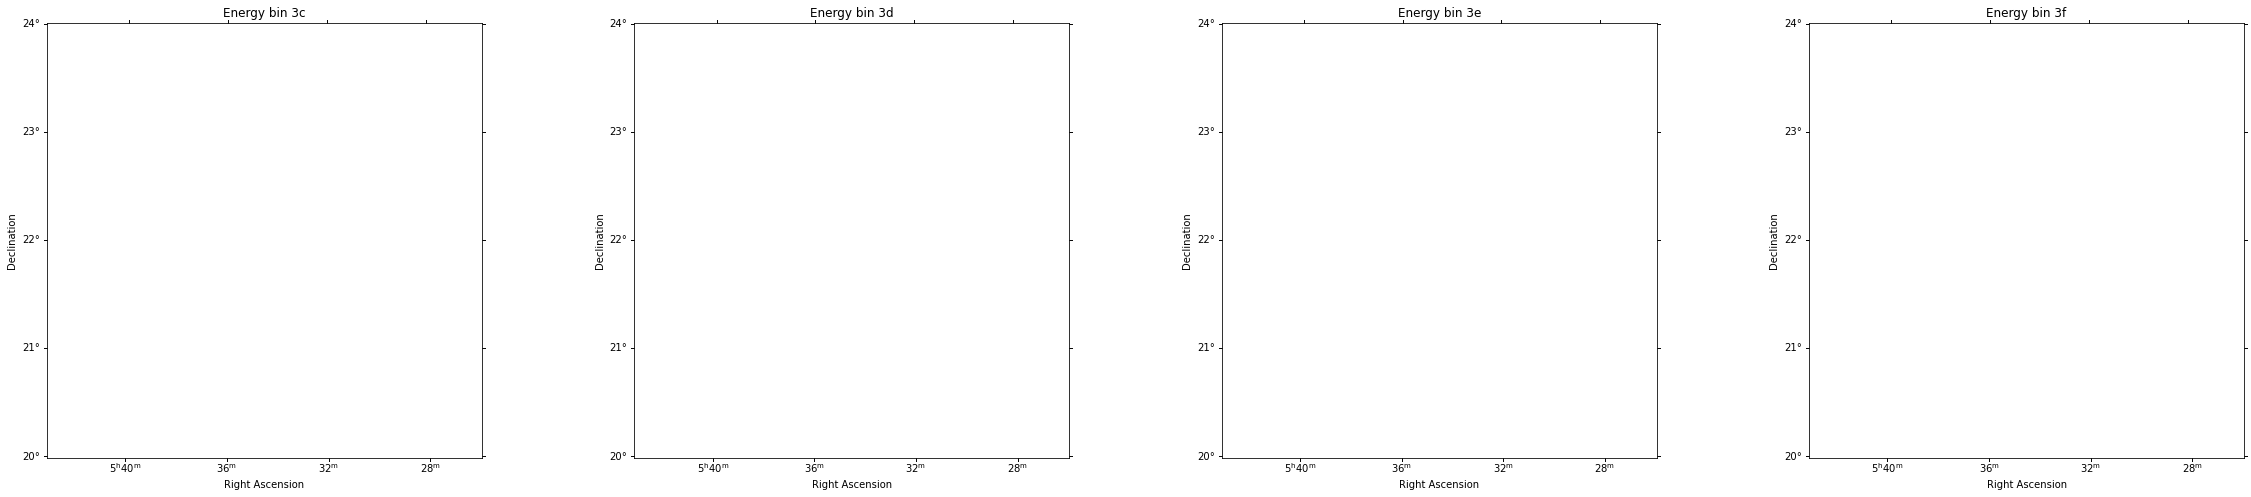

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: inval

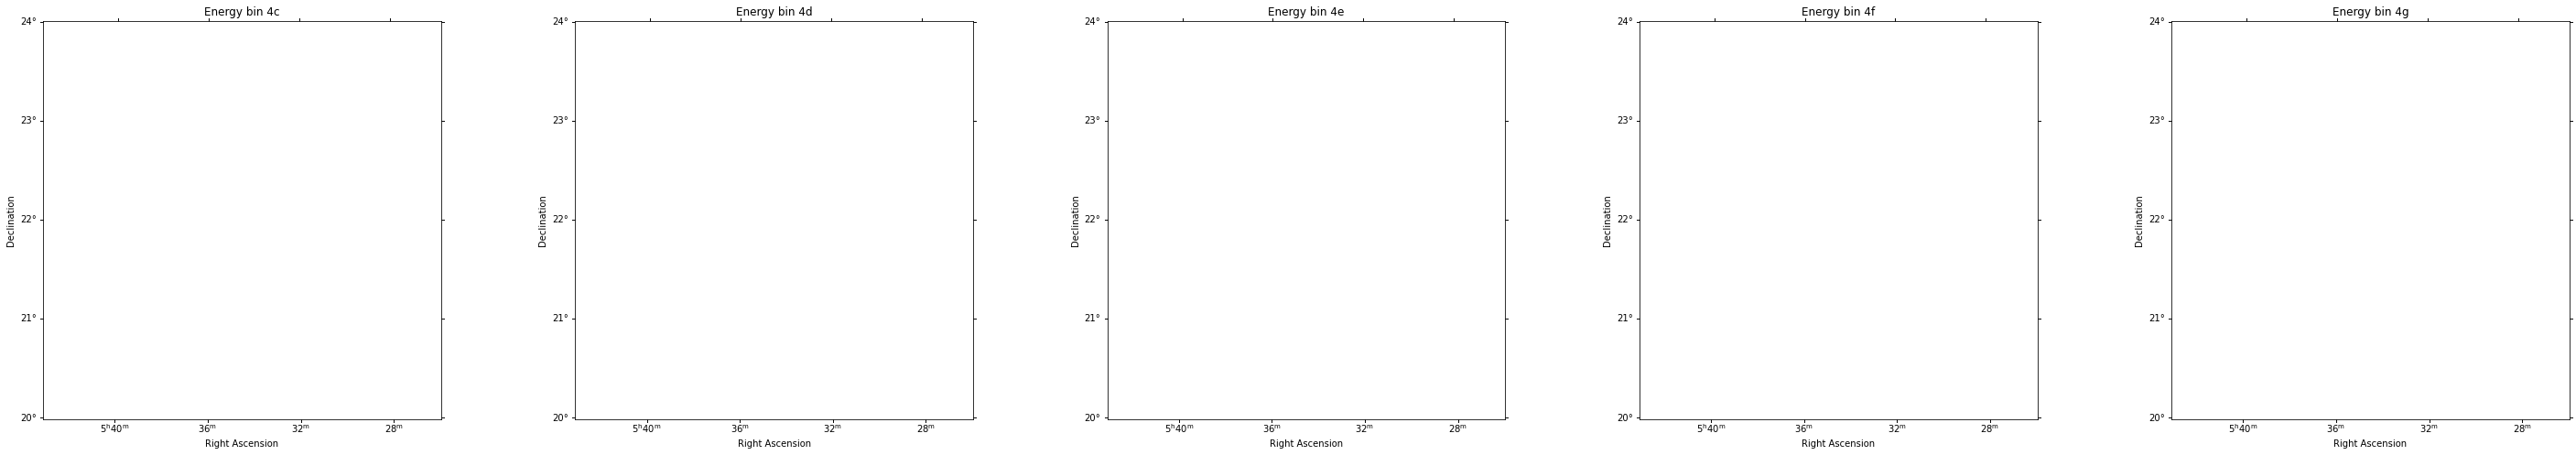

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: inval

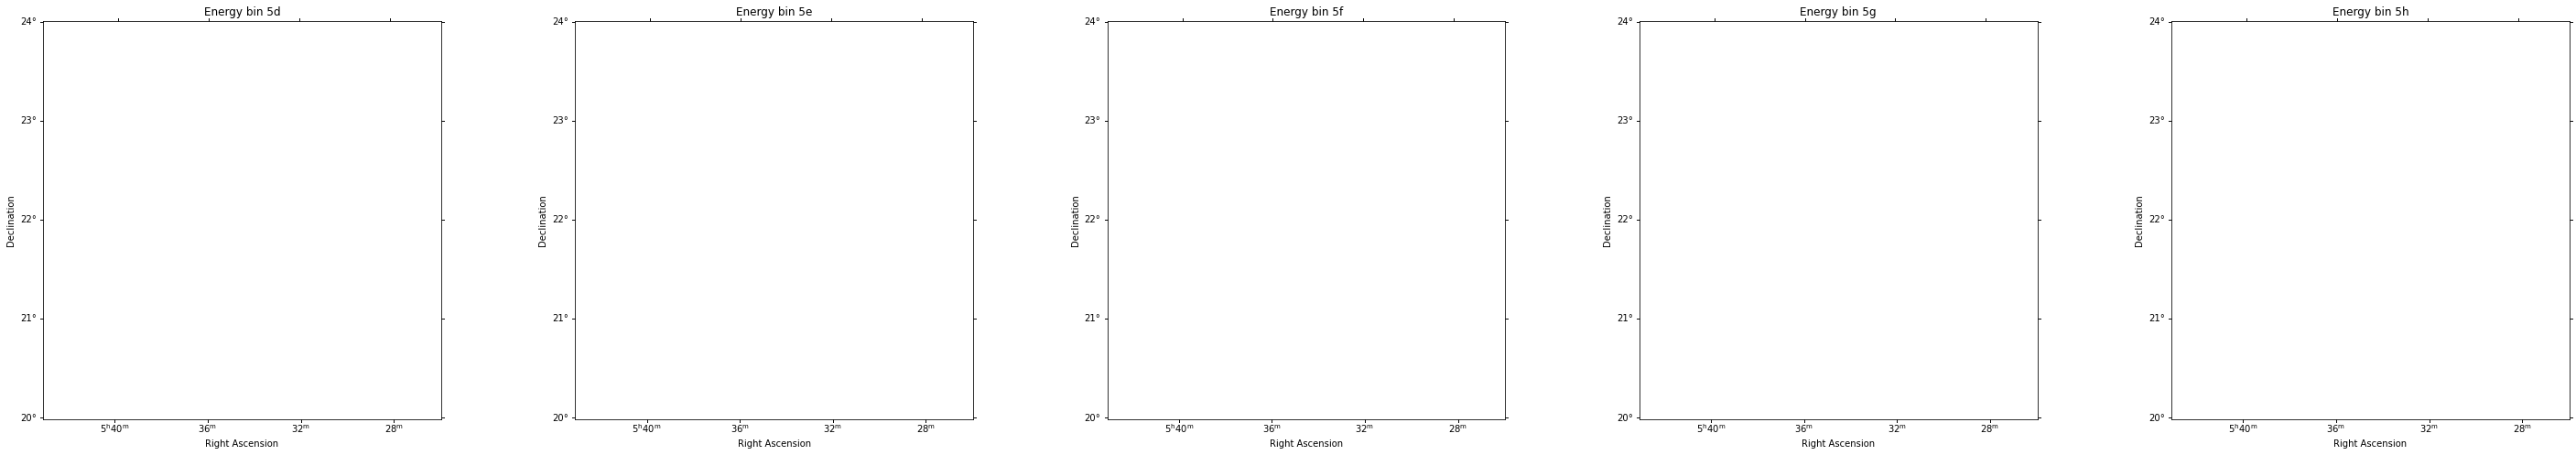

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: inval

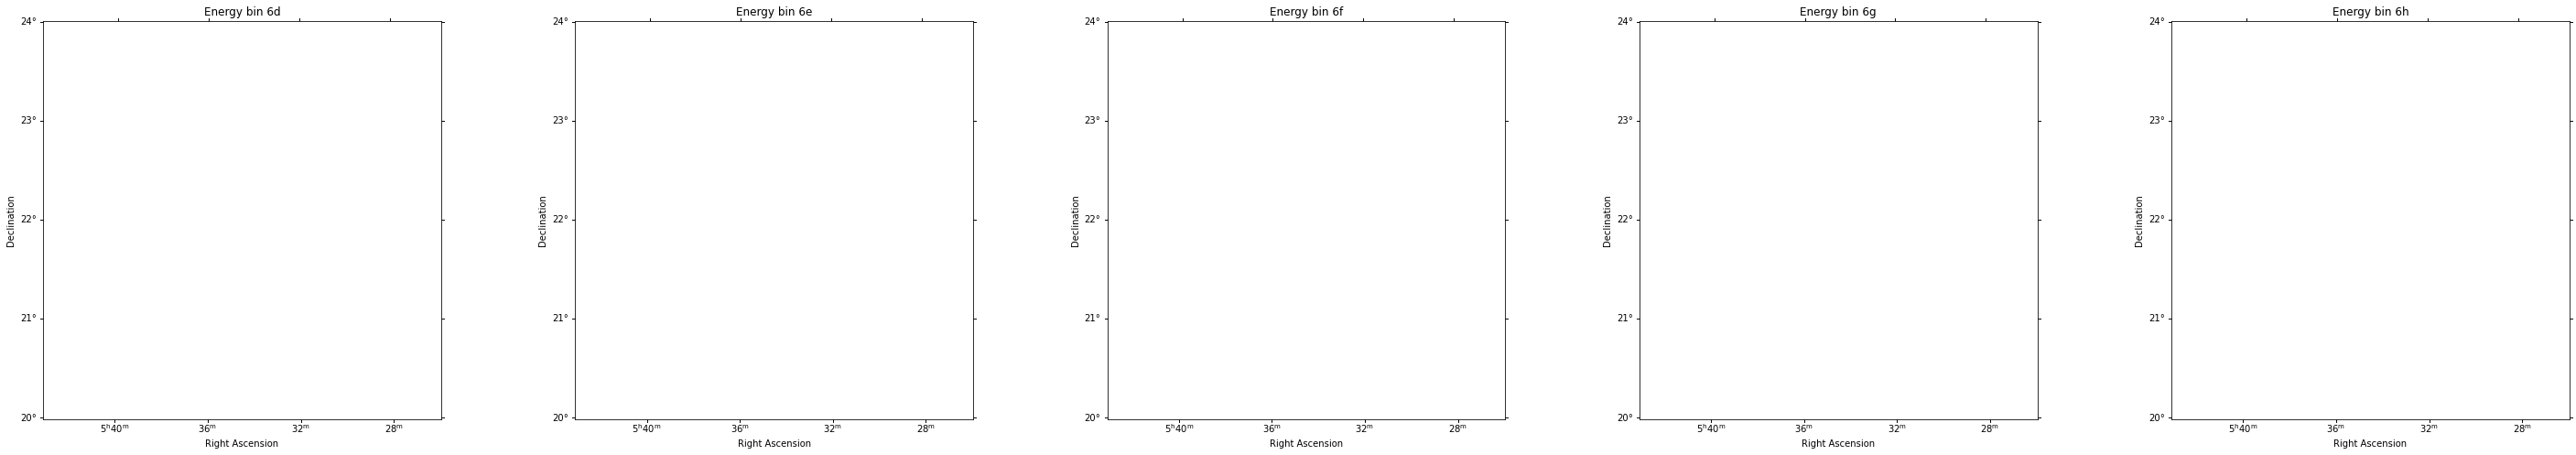

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: inval

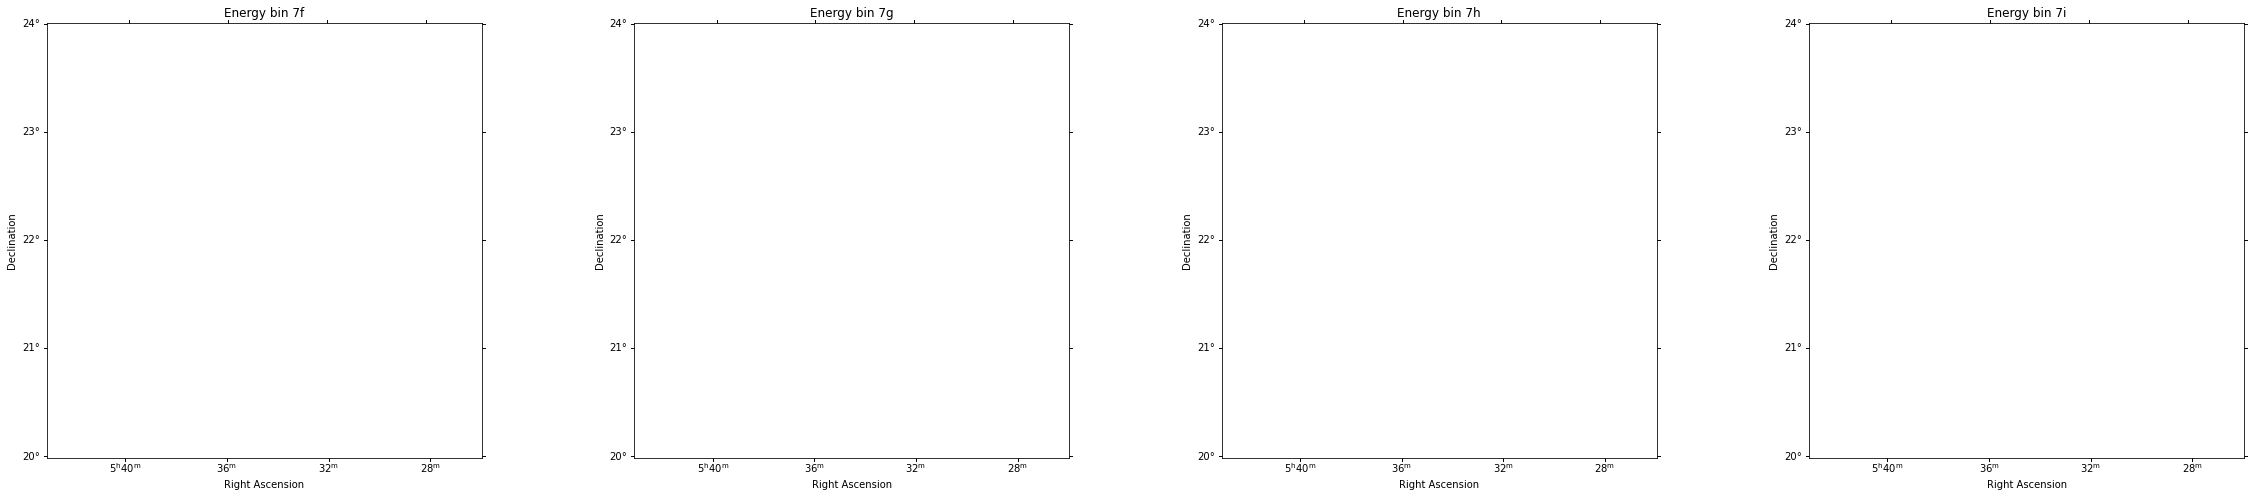

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: inval

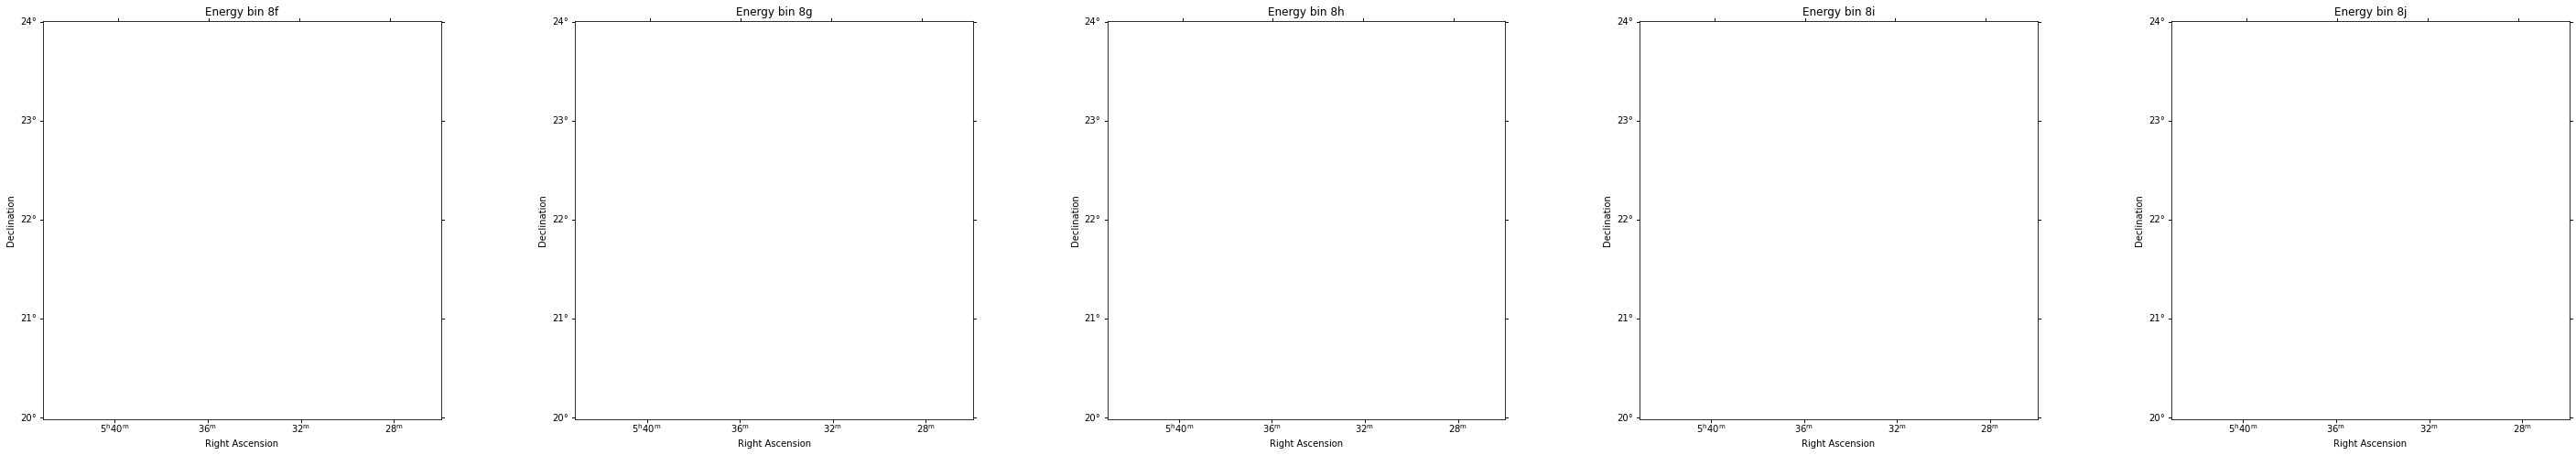

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: inval

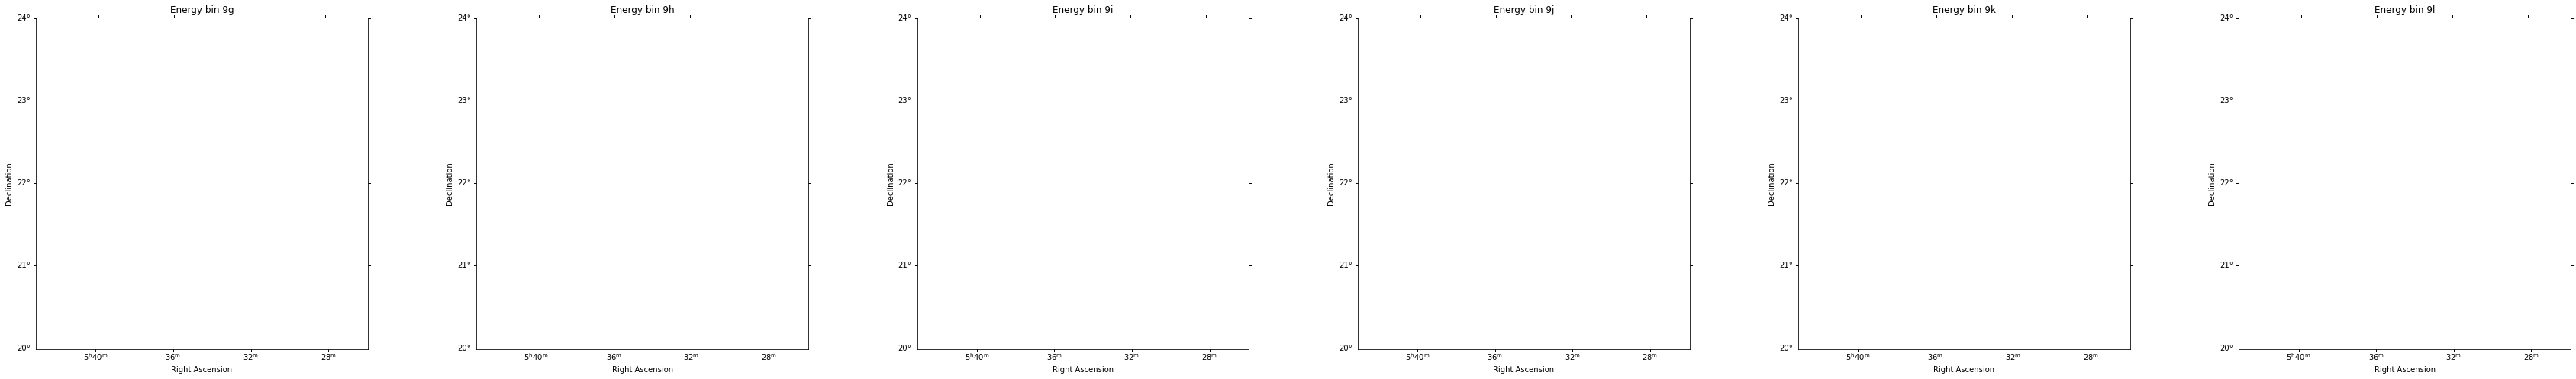

In [21]:
for i in range(9):
    plot_nhit_grid(hawc_datasets_nHitBin[i].exposure, event_class = i, cmap="viridis")
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.savefig("plots/exposure-%dnhit.png"%(i+1), dpi=180, bbox_inches='tight')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f8a369799e8>)

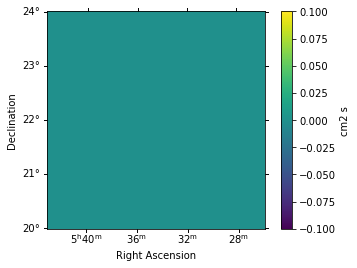

In [22]:
test = hawc_datasets_nHitBin[4].exposure
test.get_image_by_idx((10,)).plot(add_cbar=True, cmap="viridis")

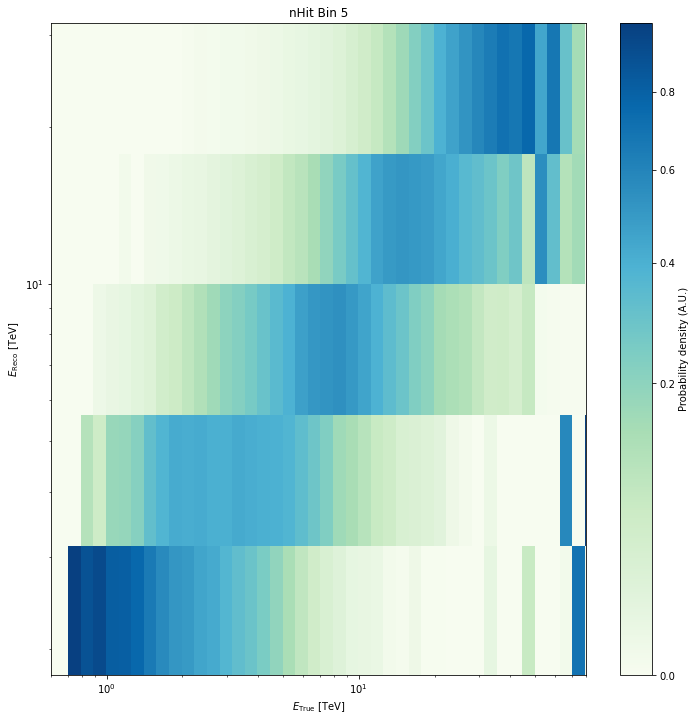

In [23]:
plt.figure(figsize=(12, 12))
example_bin = hawc_datasets_nHitBin[4].edisp.get_edisp_kernel()
ax = example_bin.plot_matrix(add_cbar=True)
ax.set_xlim(xmin=0.6, xmax=80)
ax.set_title("nHit Bin 5")
plt.savefig("plots/edisp_nhit5.png", dpi=300, bbox_inches='tight')

#### plotting contours

In [24]:
model.spectral_model.alpha.error

0.01652573685599503

In [25]:
profile = fit.stat_profile(parameter="alpha")

In [26]:
total_stat = result.total_stat
plt.plot(profile["values"], profile["stat"] - total_stat)
plt.xlabel(r"$\Gamma$")
plt.ylabel("Delta TS");

KeyError: 'values'

In [ ]:
def make_contours(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["alpha", "beta", "amplitude"], r=2):
            contour = fit.minos_contour(
                result.parameters[par_1],
                result.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour["x"].tolist(),
                par_2: contour["y"].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

In [ ]:
fit._parameters['lon_0'].frozen = True #fixing position parameters otherwise minos_contour is failing
fit._parameters['lat_0'].frozen = True
result_new = fit.optimize()
print(fit.minuit.fixed)

In [ ]:
fit.minuit.tol

In [ ]:
%%time
sigma = [1, 2]
cts_sigma = make_contours(fit, result_new, 5, sigma)

In [ ]:
pars = {
    "phi": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "alpha": r"$\alpha$",
    "beta": r"$\beta$",
}

panels = [
    {
        "x": "alpha",
        "y": "phi",
        "cx": (lambda ct: ct["contour_alpha_amplitude"]["alpha"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_alpha_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "beta",
        "y": "phi",
        "cx": (lambda ct: ct["contour_beta_amplitude"]["beta"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_beta_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "alpha",
        "y": "beta",
        "cx": (lambda ct: ct["contour_alpha_beta"]["alpha"]),
        "cy": (lambda ct: ct["contour_alpha_beta"]["beta"]),
    },
]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(
            ax,
            p["cx"](cts_sigma[ks]),
            p["cy"](cts_sigma[ks]),
            lw=2.5,
            color=colors[ks],
            label=f"{sigma[ks]}" + r"$\sigma$",
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()

In [ ]:
center_dec_bins = np.arange(-90,90,5)
idx = (np.abs(center_dec_bins - 22.01)).argmin()
print(center_dec_bins[idx])

In [ ]:
for i in range(1,10):
    print(i)

In [ ]:
np.log10(0.)